In [38]:
import ast
import os
import warnings
import re
from datetime import datetime

import isort
import emoji
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, date2num
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
import statsmodels as sm
from arch import arch_model
from pmdarima.arima import auto_arima
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.arima.model import ARIMA

from functions import *
from scripts import *

warnings.simplefilter(action='ignore', category=FutureWarning)
set_plot_style()

<Figure size 3600x1800 with 0 Axes>

# Import datasets

In [2]:
data = import_and_preprocess_data_stock(symbol="AAPL")
data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Volatility,Return,Log_Return
0,2013-01-02 00:00:00-05:00,16.814443,16.850269,16.444345,16.669014,560518000,0.0,0.0,0.405924,NaN,NaN
1,2013-01-03 00:00:00-05:00,16.634106,16.688452,16.425223,16.458620,352965200,0.0,0.0,0.263229,-0.012622,-0.012702
2,2013-01-04 00:00:00-05:00,16.302868,16.353267,15.964647,16.000170,594333600,0.0,0.0,0.388620,-0.027855,-0.028250
3,2013-01-07 00:00:00-05:00,15.848357,16.069990,15.641903,15.906043,484156400,0.0,0.0,0.428087,-0.005883,-0.005900
4,2013-01-08 00:00:00-05:00,16.067263,16.148630,15.825592,15.948855,458707200,0.0,0.0,0.323039,0.002692,0.002688
...,...,...,...,...,...,...,...,...,...,...,...
2513,2022-12-23 00:00:00-05:00,129.415299,130.898059,128.150012,130.344498,63814900,0.0,0.0,2.748047,-0.002798,-0.002802
2514,2022-12-27 00:00:00-05:00,129.869997,129.899651,127.240566,128.535507,69007800,0.0,0.0,2.659085,-0.013879,-0.013976
2515,2022-12-28 00:00:00-05:00,128.179661,129.524031,124.423341,124.591385,85438400,0.0,0.0,5.100691,-0.030685,-0.031166
2516,2022-12-29 00:00:00-05:00,126.518963,128.980342,126.261956,128.120346,75703700,0.0,0.0,2.718386,0.028324,0.027931


In [121]:
tweets = pd.read_parquet("data/tweets_processed_with_sentiment.parquet")
display(tweets)

,id,body,date,user,source,symbols,owned_symbols,mentioned_users,entities,conversation,...,reshares,reshare_message,structurable,sentiment_base,body_cleaned,likes_total,likes_ponderation,sentiment_vader,sentiment_finbert,sentiment_roberta
0,188952625,$AAPL there is some smarty money trimming into...,2020-01-03,"{'id': 646025, 'username': 'WalterWhitesMoney'...","{'id': 1149, 'title': 'StockTwits for iOS', 'u...","[{'id': 686, 'symbol': 'AAPL', 'title': 'Apple...","['9', '4', '5', '0', '5', '12', '0', '0', '0',...",[],{'sentiment': None},None,...,None,None,None,nan,cashtag_AAPL there is some smarty money trimmi...,0,1.000000,Neutral,Bullish,Bearish
1,188952404,$AAPL boom!,2020-01-03,"{'id': 2975791, 'username': 'IntradayTradesmen...","{'id': 1149, 'title': 'StockTwits for iOS', 'u...","[{'id': 686, 'symbol': 'AAPL', 'title': 'Apple...","['21', '12', '9', '0', '9', '5', '0', '4', '0'...",[],{'sentiment': None},None,...,None,None,None,nan,cashtag_AAPL boom!,0,1.000000,Neutral,Bullish,Bullish
2,188952295,$AAPL this pos will not fall below mid VWAP.,2020-01-03,"{'id': 2975791, 'username': 'IntradayTradesmen...","{'id': 1149, 'title': 'StockTwits for iOS', 'u...","[{'id': 686, 'symbol': 'AAPL', 'title': 'Apple...","['20', '11', '9', '0', '9', '5', '0', '4', '0'...",[],{'sentiment': None},"{'parent_message_id': 188952295, 'in_reply_to_...",...,None,None,None,nan,cashtag_AAPL this pos will not fall below mid ...,0,1.000000,Neutral,Bullish,Bearish
3,188952260,$AAPL I am holding going to see what this bab...,2020-01-03,"{'id': 2083522, 'username': 'robertlooney', 'n...","{'id': 2095, 'title': 'StockTwits For Android ...","[{'id': 686, 'symbol': 'AAPL', 'title': 'Apple...","['4', '4', '0', '0', '0', '3', '0', '0', '0', ...",[],{'sentiment': {'basic': 'Bullish'}},None,...,None,None,None,Bullish,cashtag_AAPL I am holding going to see what t...,1,1.414214,Bullish,Bullish,Bullish
4,188951817,$SPY is $AAPL over priced is the average analy...,2020-01-03,"{'id': 1581841, 'username': 'CaymanStyleBeef',...","{'id': 2095, 'title': 'StockTwits For Android ...","[{'id': 686, 'symbol': 'AAPL', 'title': 'Apple...","['3', '2', '1', '0', '1', '1', '0', '1', '0', ...",[],{'sentiment': None},"{'parent_message_id': 188951817, 'in_reply_to_...",...,None,None,None,nan,cashtag_SPY is cashtag_AAPL over priced is the...,0,1.000000,Neutral,Bullish,Bearish
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914957,433483243,$AAPL break 171 and she flushes,2022-02-04,"{'id': 6291642, 'username': 'Russianrussian', ...","{'id': 1149, 'title': 'StockTwits for iOS', 'u...","[{'id': 686, 'symbol': 'AAPL', 'title': 'Apple...",None,[],{'sentiment': {'basic': 'Bearish'}},"{'parent_message_id': 433483243, 'in_reply_to_...",...,None,None,None,Bearish,cashtag_AAPL break 171 and she flushes,2,1.732051,Neutral,Bullish,Bearish
914958,433483137,$AAPL is a growth stock now?,2022-02-04,"{'id': 6287247, 'username': 'TheMarketIsRigged...","{'id': 1149, 'title': 'StockTwits for iOS', 'u...","[{'id': 686, 'symbol': 'AAPL', 'title': 'Apple...",None,[],{'sentiment': None},None,...,None,None,None,nan,cashtag_AAPL is a growth stock now?,0,1.000000,Bullish,Bullish,Bearish
914959,433482209,"$AAPL 🍏 Do you know what time it is…yep, that...",2022-02-04,"{'id': 819540, 'username': 'hoyasaxa1978', 'na...","{'id': 1149, 'title': 'StockTwits for iOS', 'u...","[{'id': 686, 'symbol': 'AAPL', 'title': 'Apple...",None,[],{'sentiment': {'basic': 'Bullish'}},None,...,None,None,None,Bullish,cashtag_AAPL :green_apple: Do you know what t...,0,1.000000,Neutral,Bullish,Bullish
914960,433482173,"$AAPL lol u buy the dip on it, not like $tsla",2022-02-04,"{'id': 1223497, 'username': 'RNAlivesmatter', ...","{'id': 2269, 'title': 'StockTwits Web', 'url':...","[{'id': 686, 'symbol': 'AAPL', 'title': 'Apple...",None,[],{'sentiment': {'basic': 'Bullish'}},None,...,None,None,None,Bullish,"cashtag_AAPL lol u buy the dip on it, not like...",0,1.000000,Bullish,Bullish,Bullish


# EDA

## EDA - Apple Stock Price

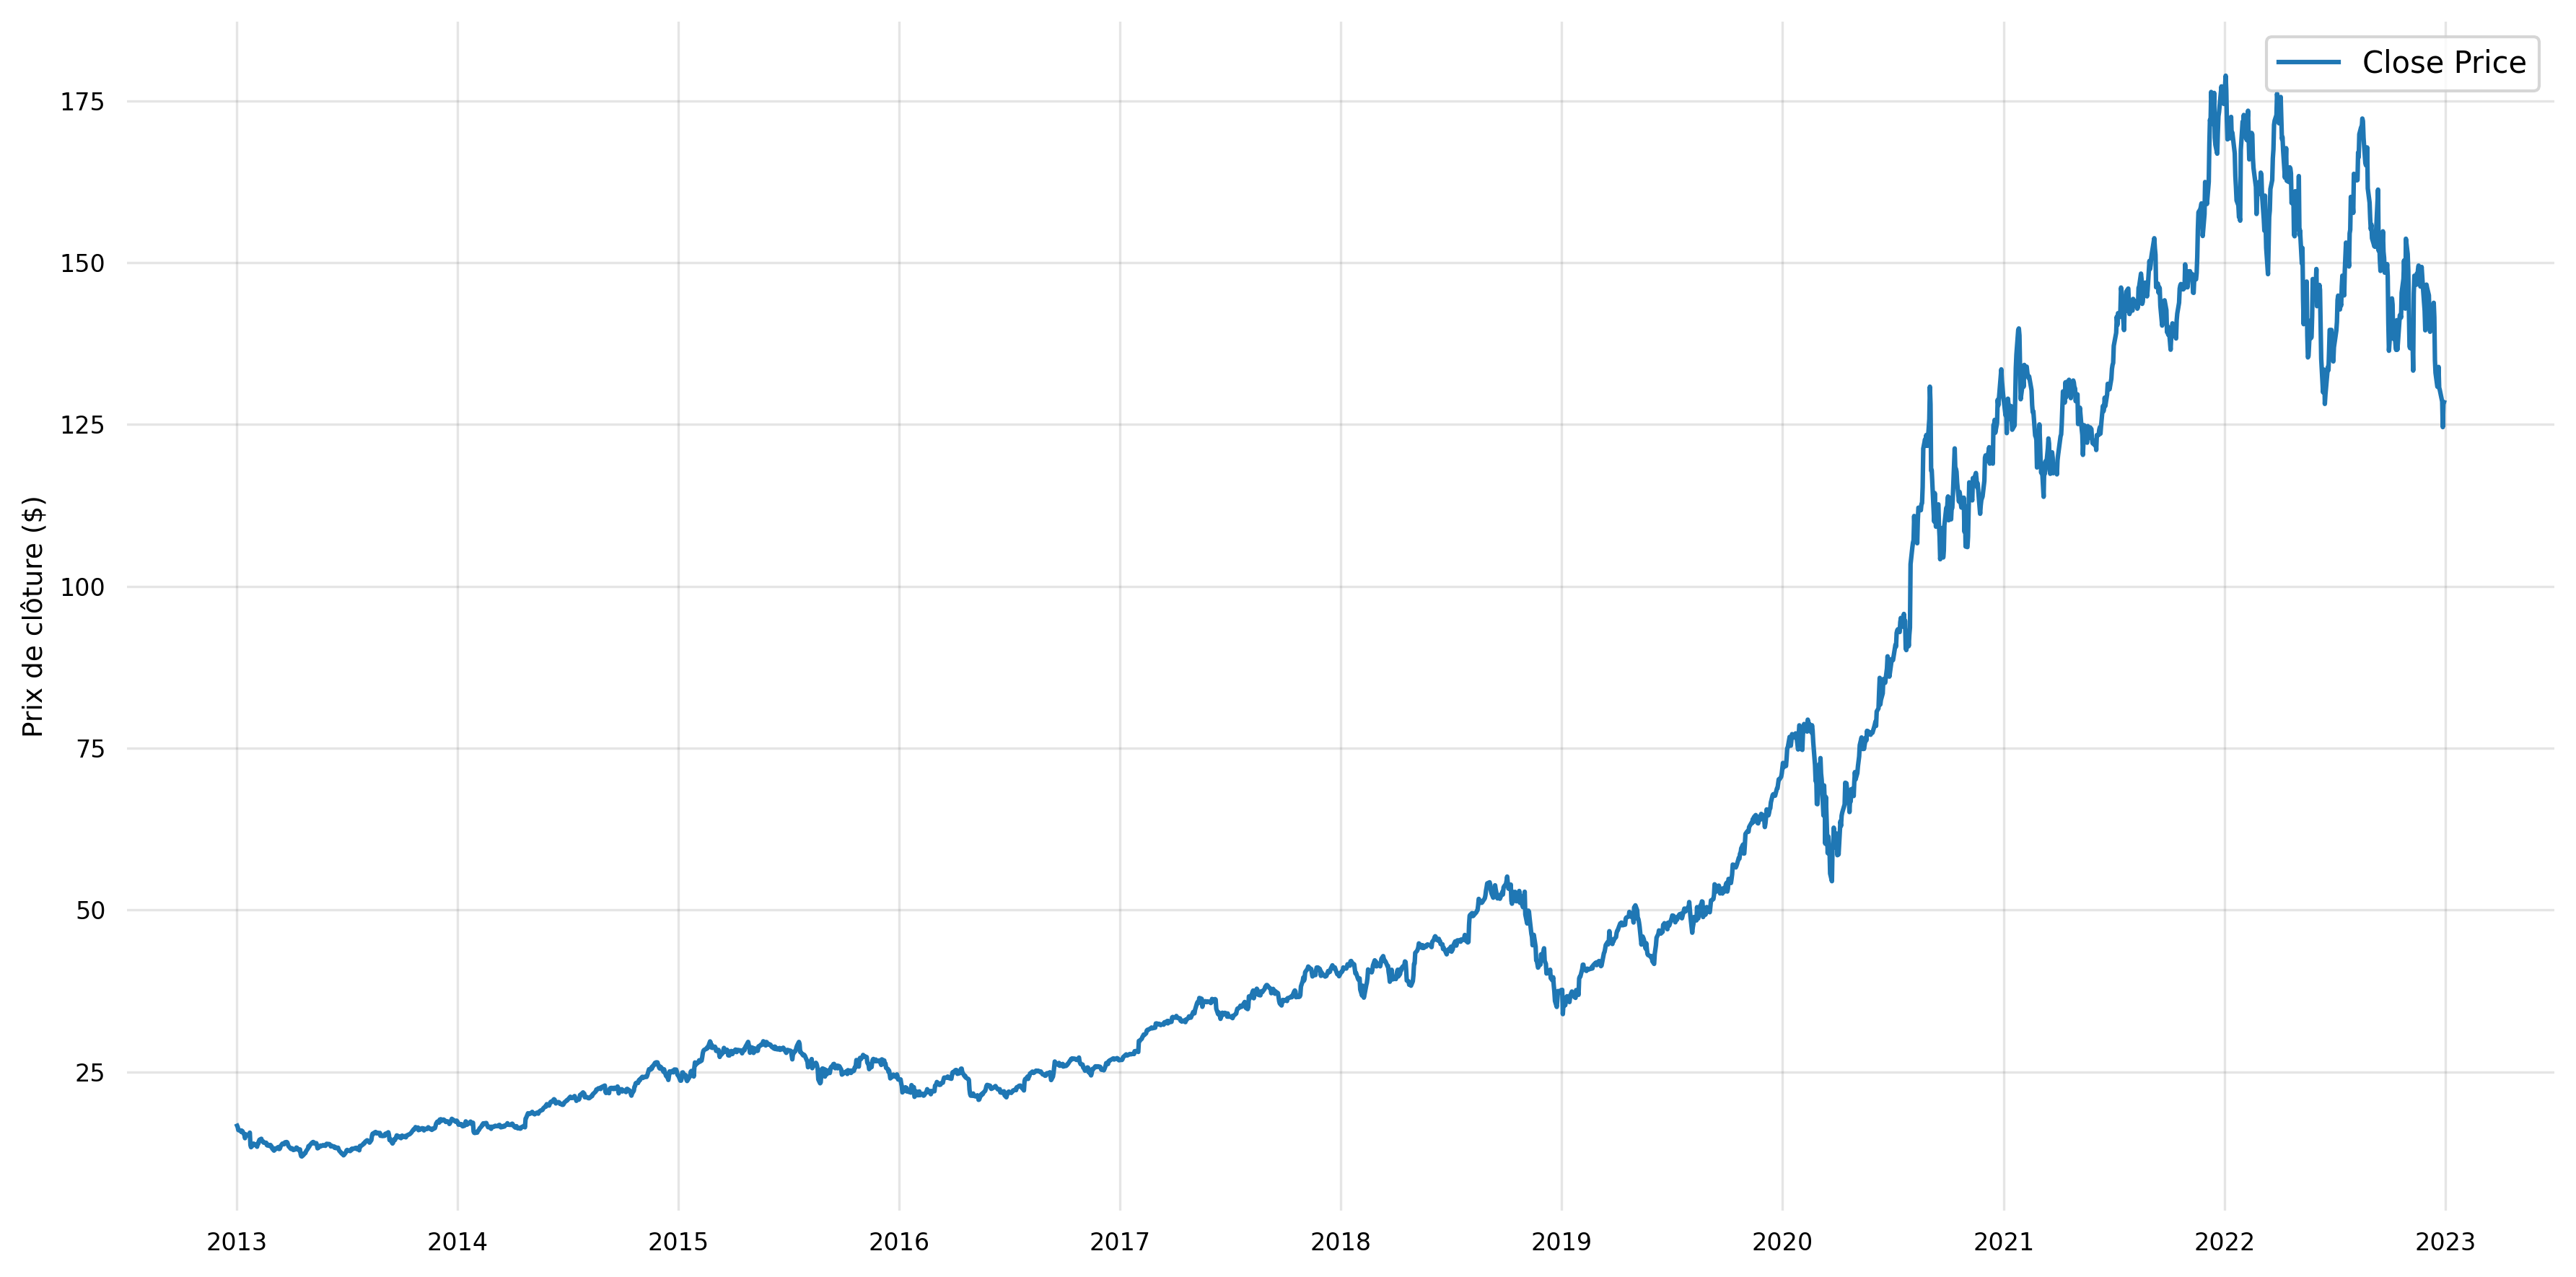

In [4]:
plt.plot(data['Date'], data['Close'], label='Close Price')
plt.ylabel("Prix de clôture ($)")
plt.legend()
plt.tight_layout()
plt.show()

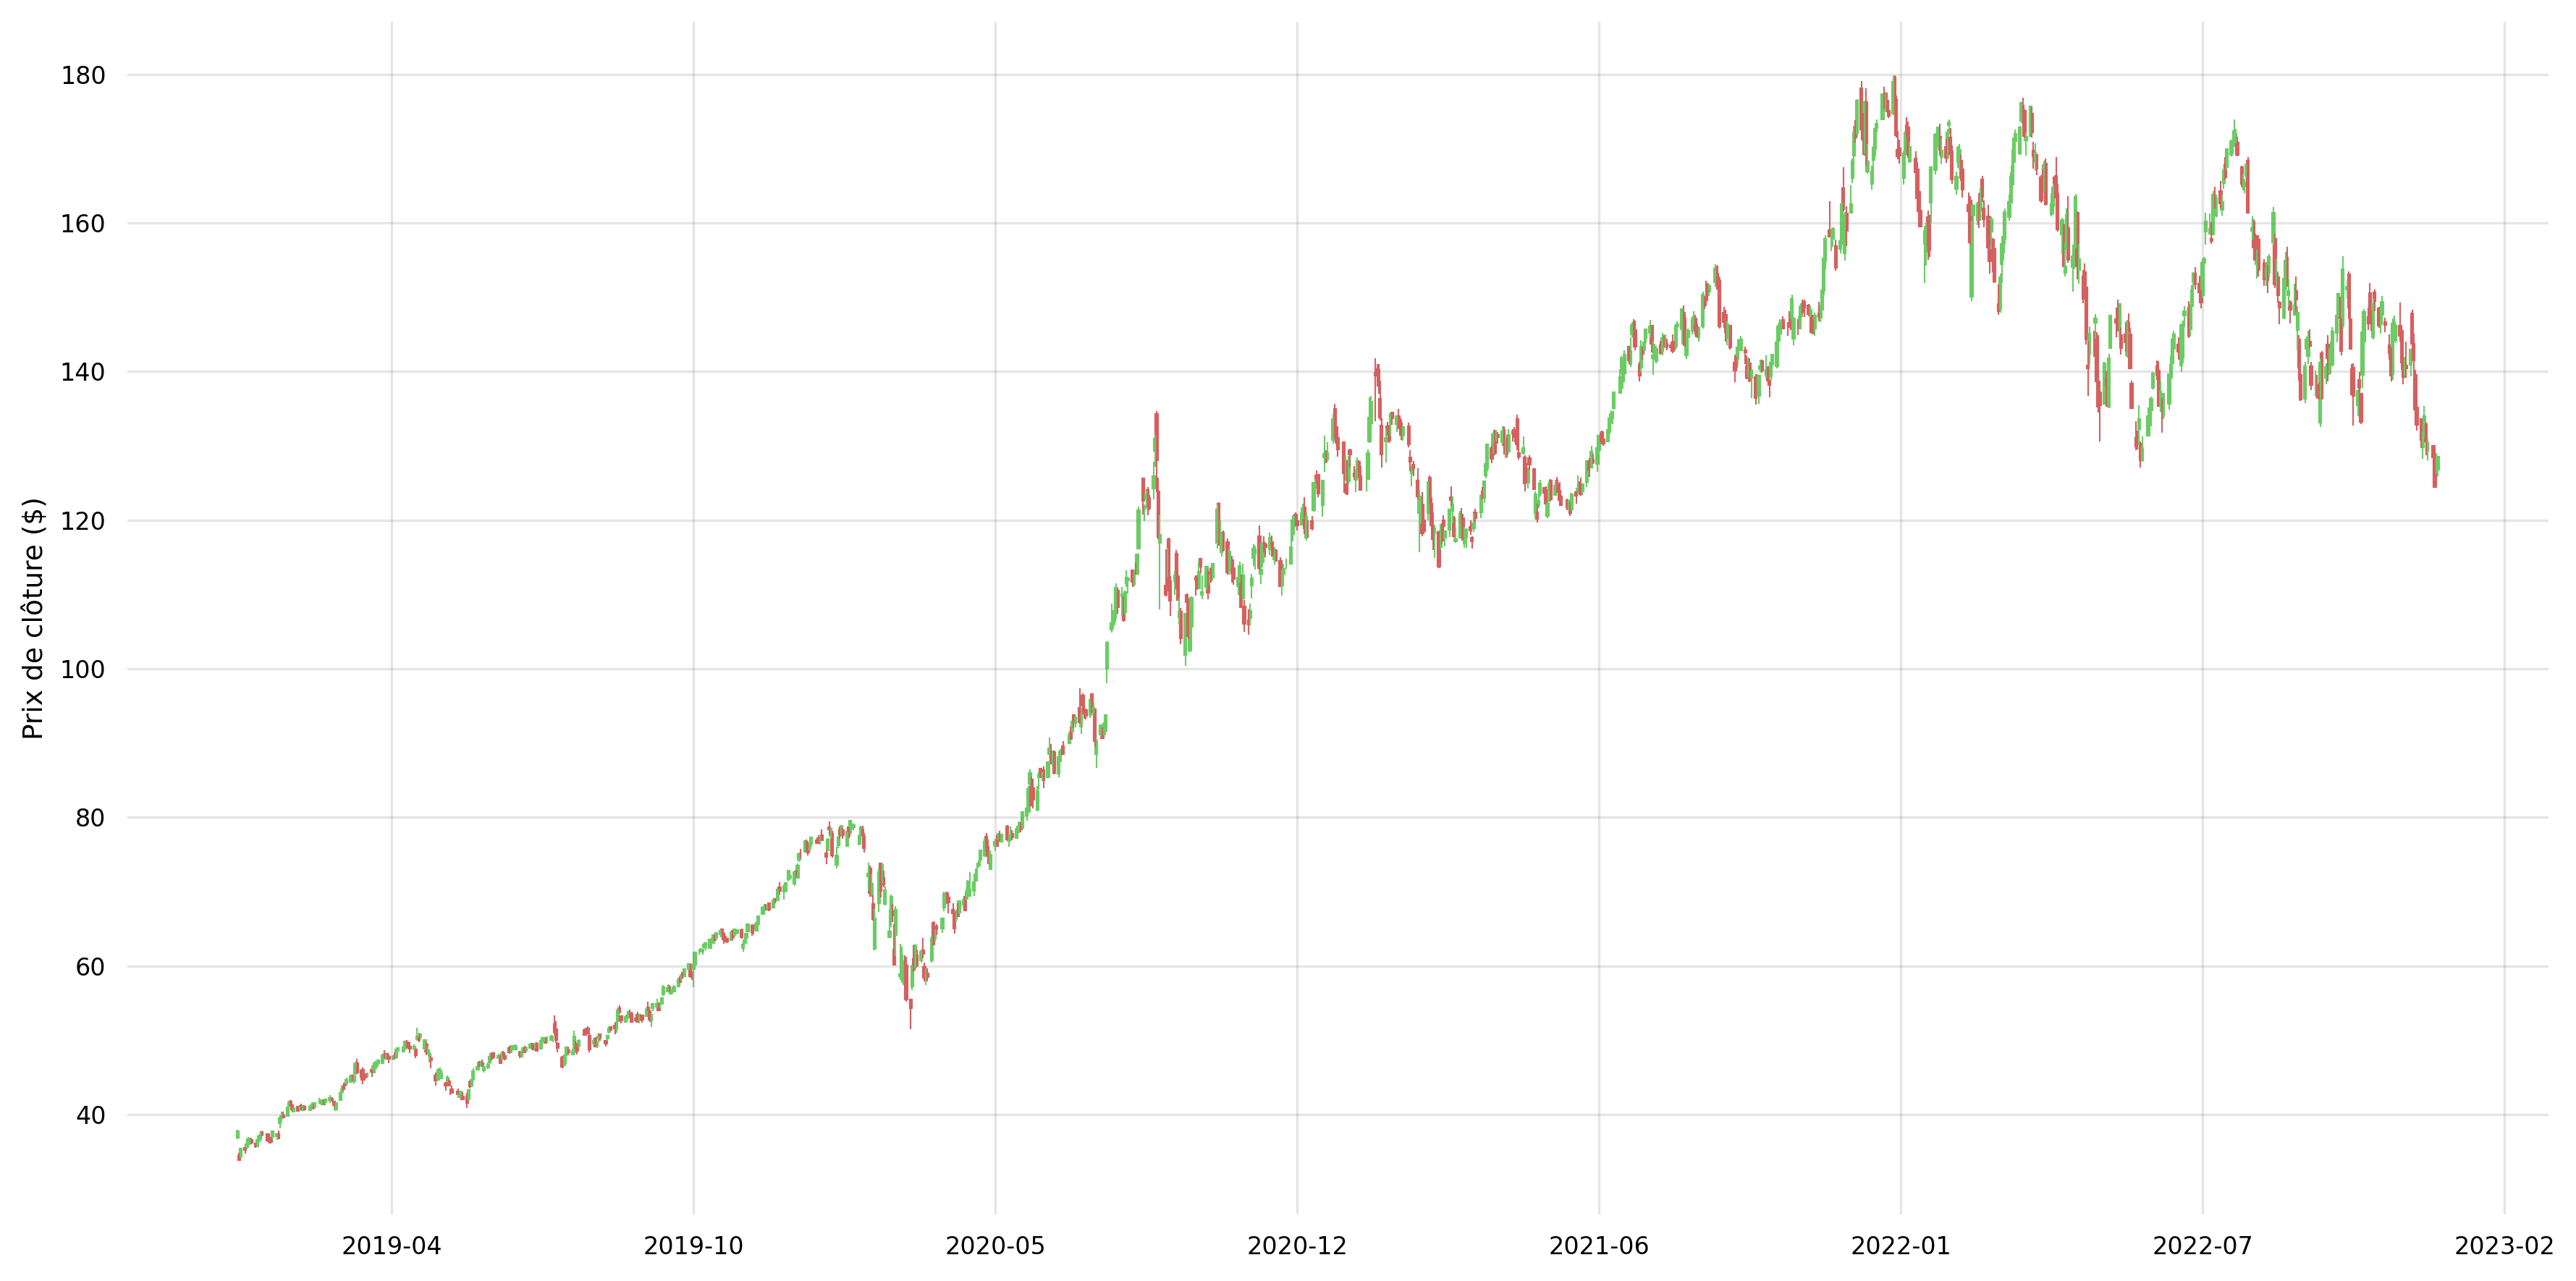

In [ ]:

data['Date_num'] = date2num(data['Date'])
data['MA10'] = data['Close'].rolling(window=10).mean()
data['MA2'] = data['Close'].rolling(window=2).mean()
quotes = [tuple(x) for x in data[['Date_num', 'Open', 'High', 'Low', 'Close']].values]

# Plot
fig, ax = plt.subplots(figsize=(12, 6))  # You can set tight layout manually
from mplfinance.original_flavor import candlestick_ohlc
candlestick_ohlc(ax, quotes, width=0.6, colorup='g', colordown='r')

# Format x-axis
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.ylabel("Prix de clôture ($)")
# Tight layout
plt.tight_layout()
plt.show()

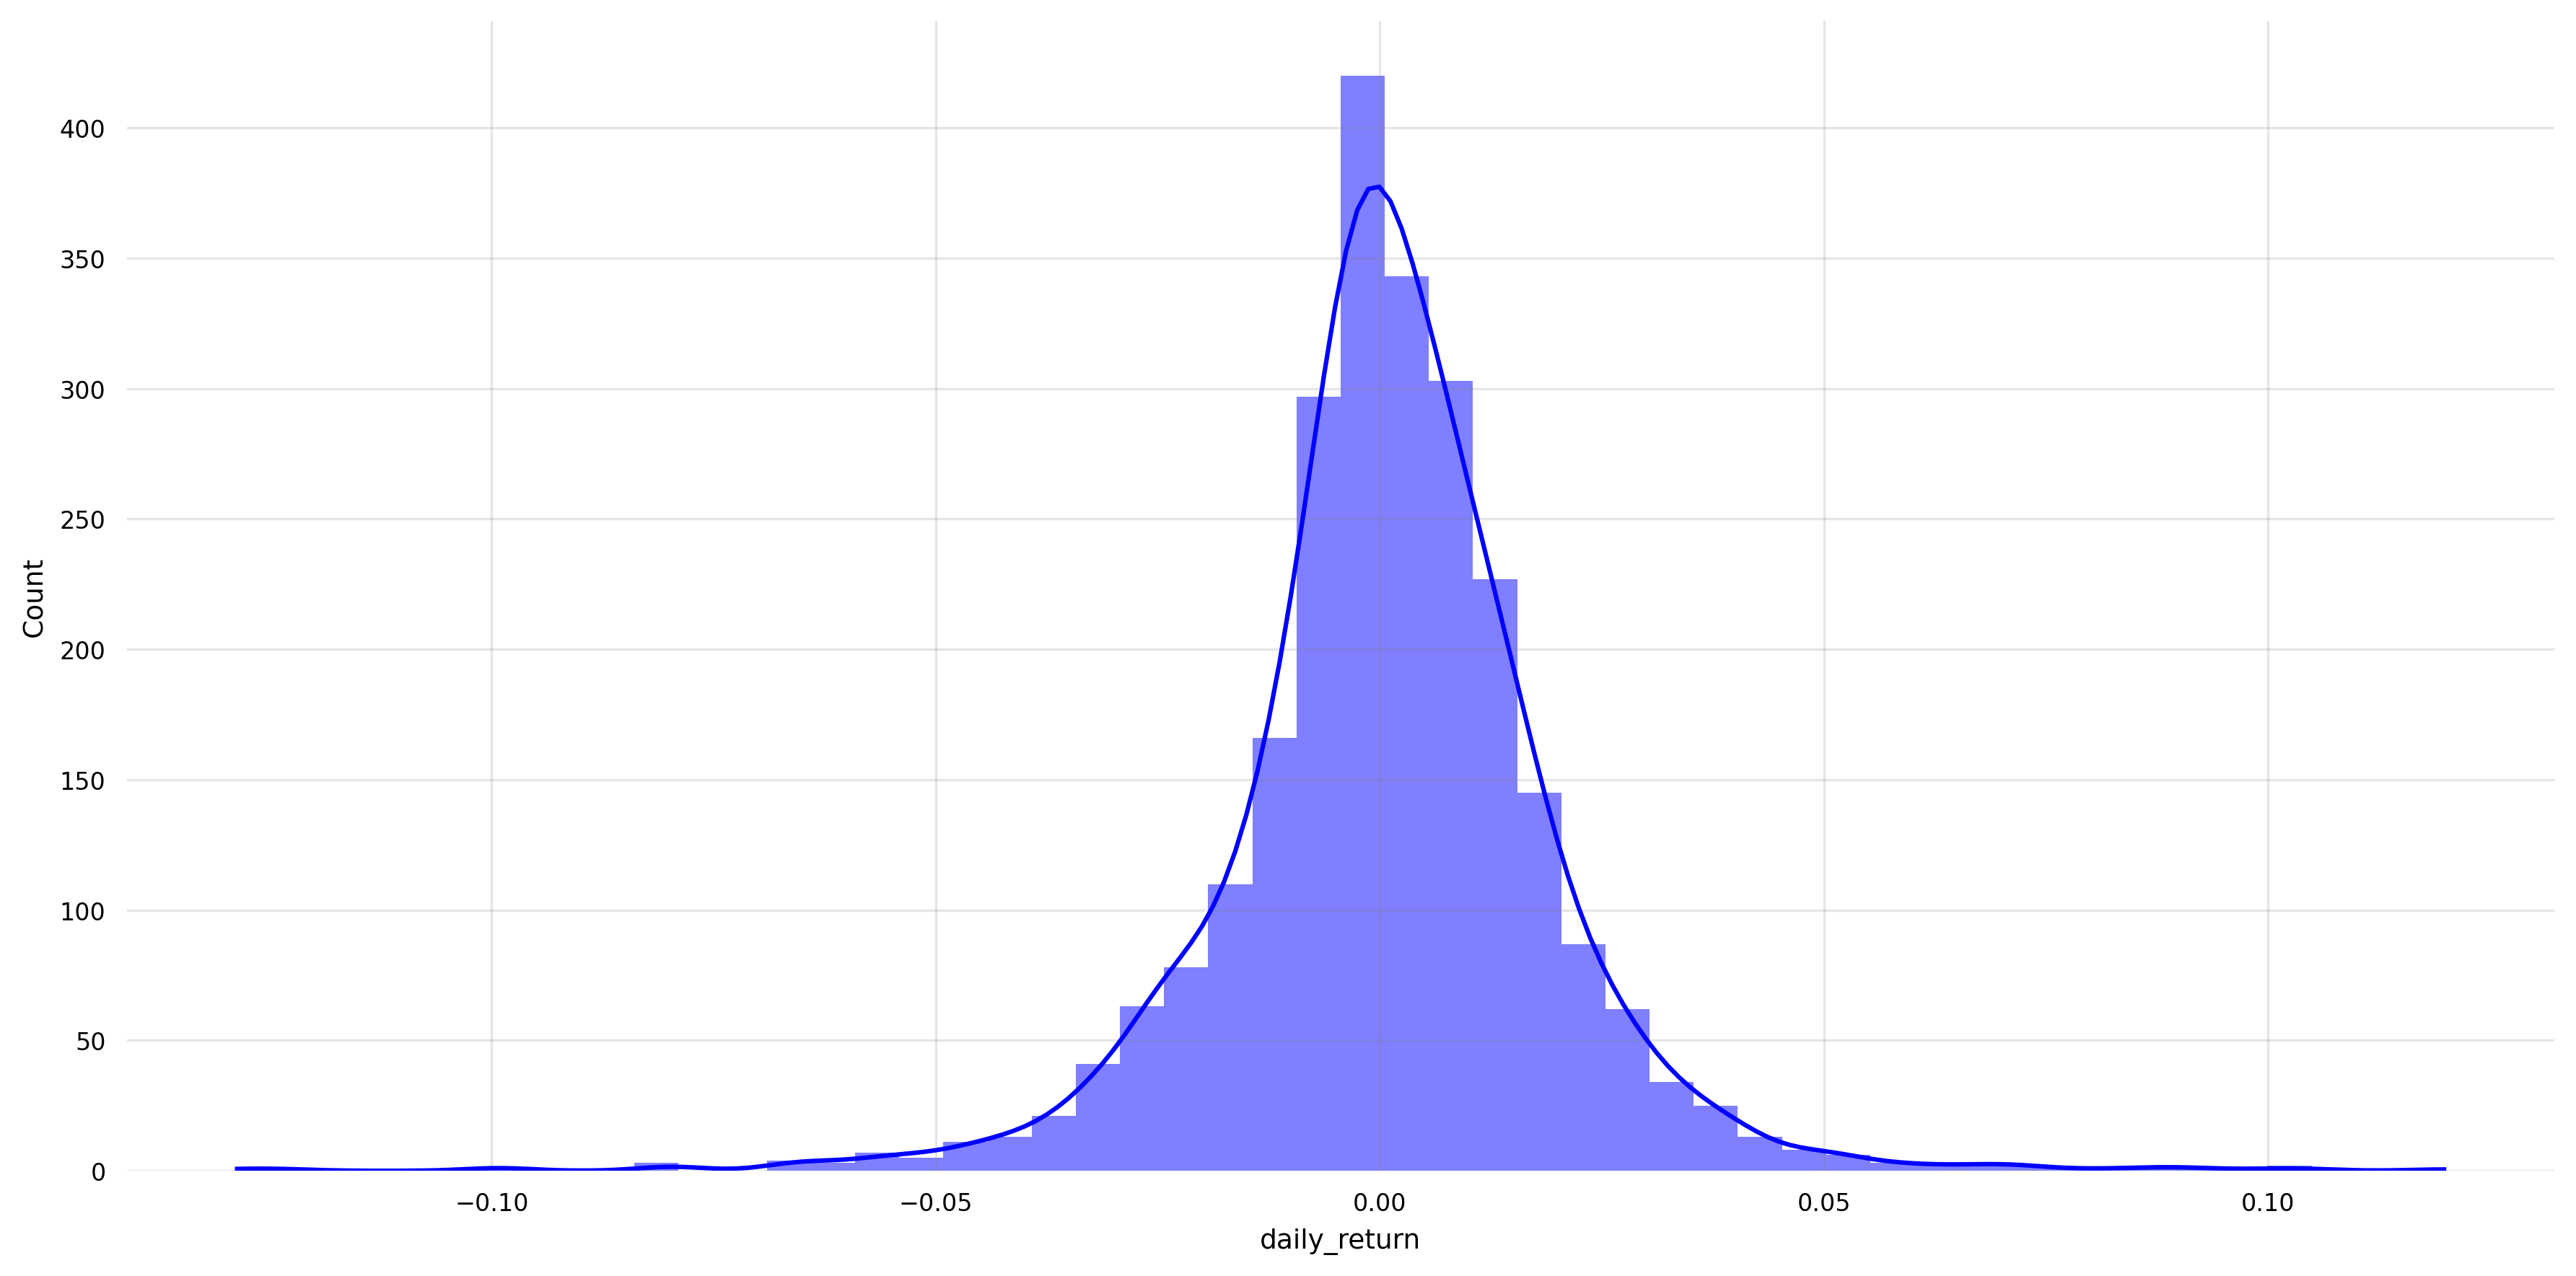

In [25]:
data['daily_return'] = data['Close'].pct_change()
sns.histplot(data['daily_return'], bins=50, kde=True, alpha=0.5, color='blue', edgecolor=None)
plt.tight_layout()

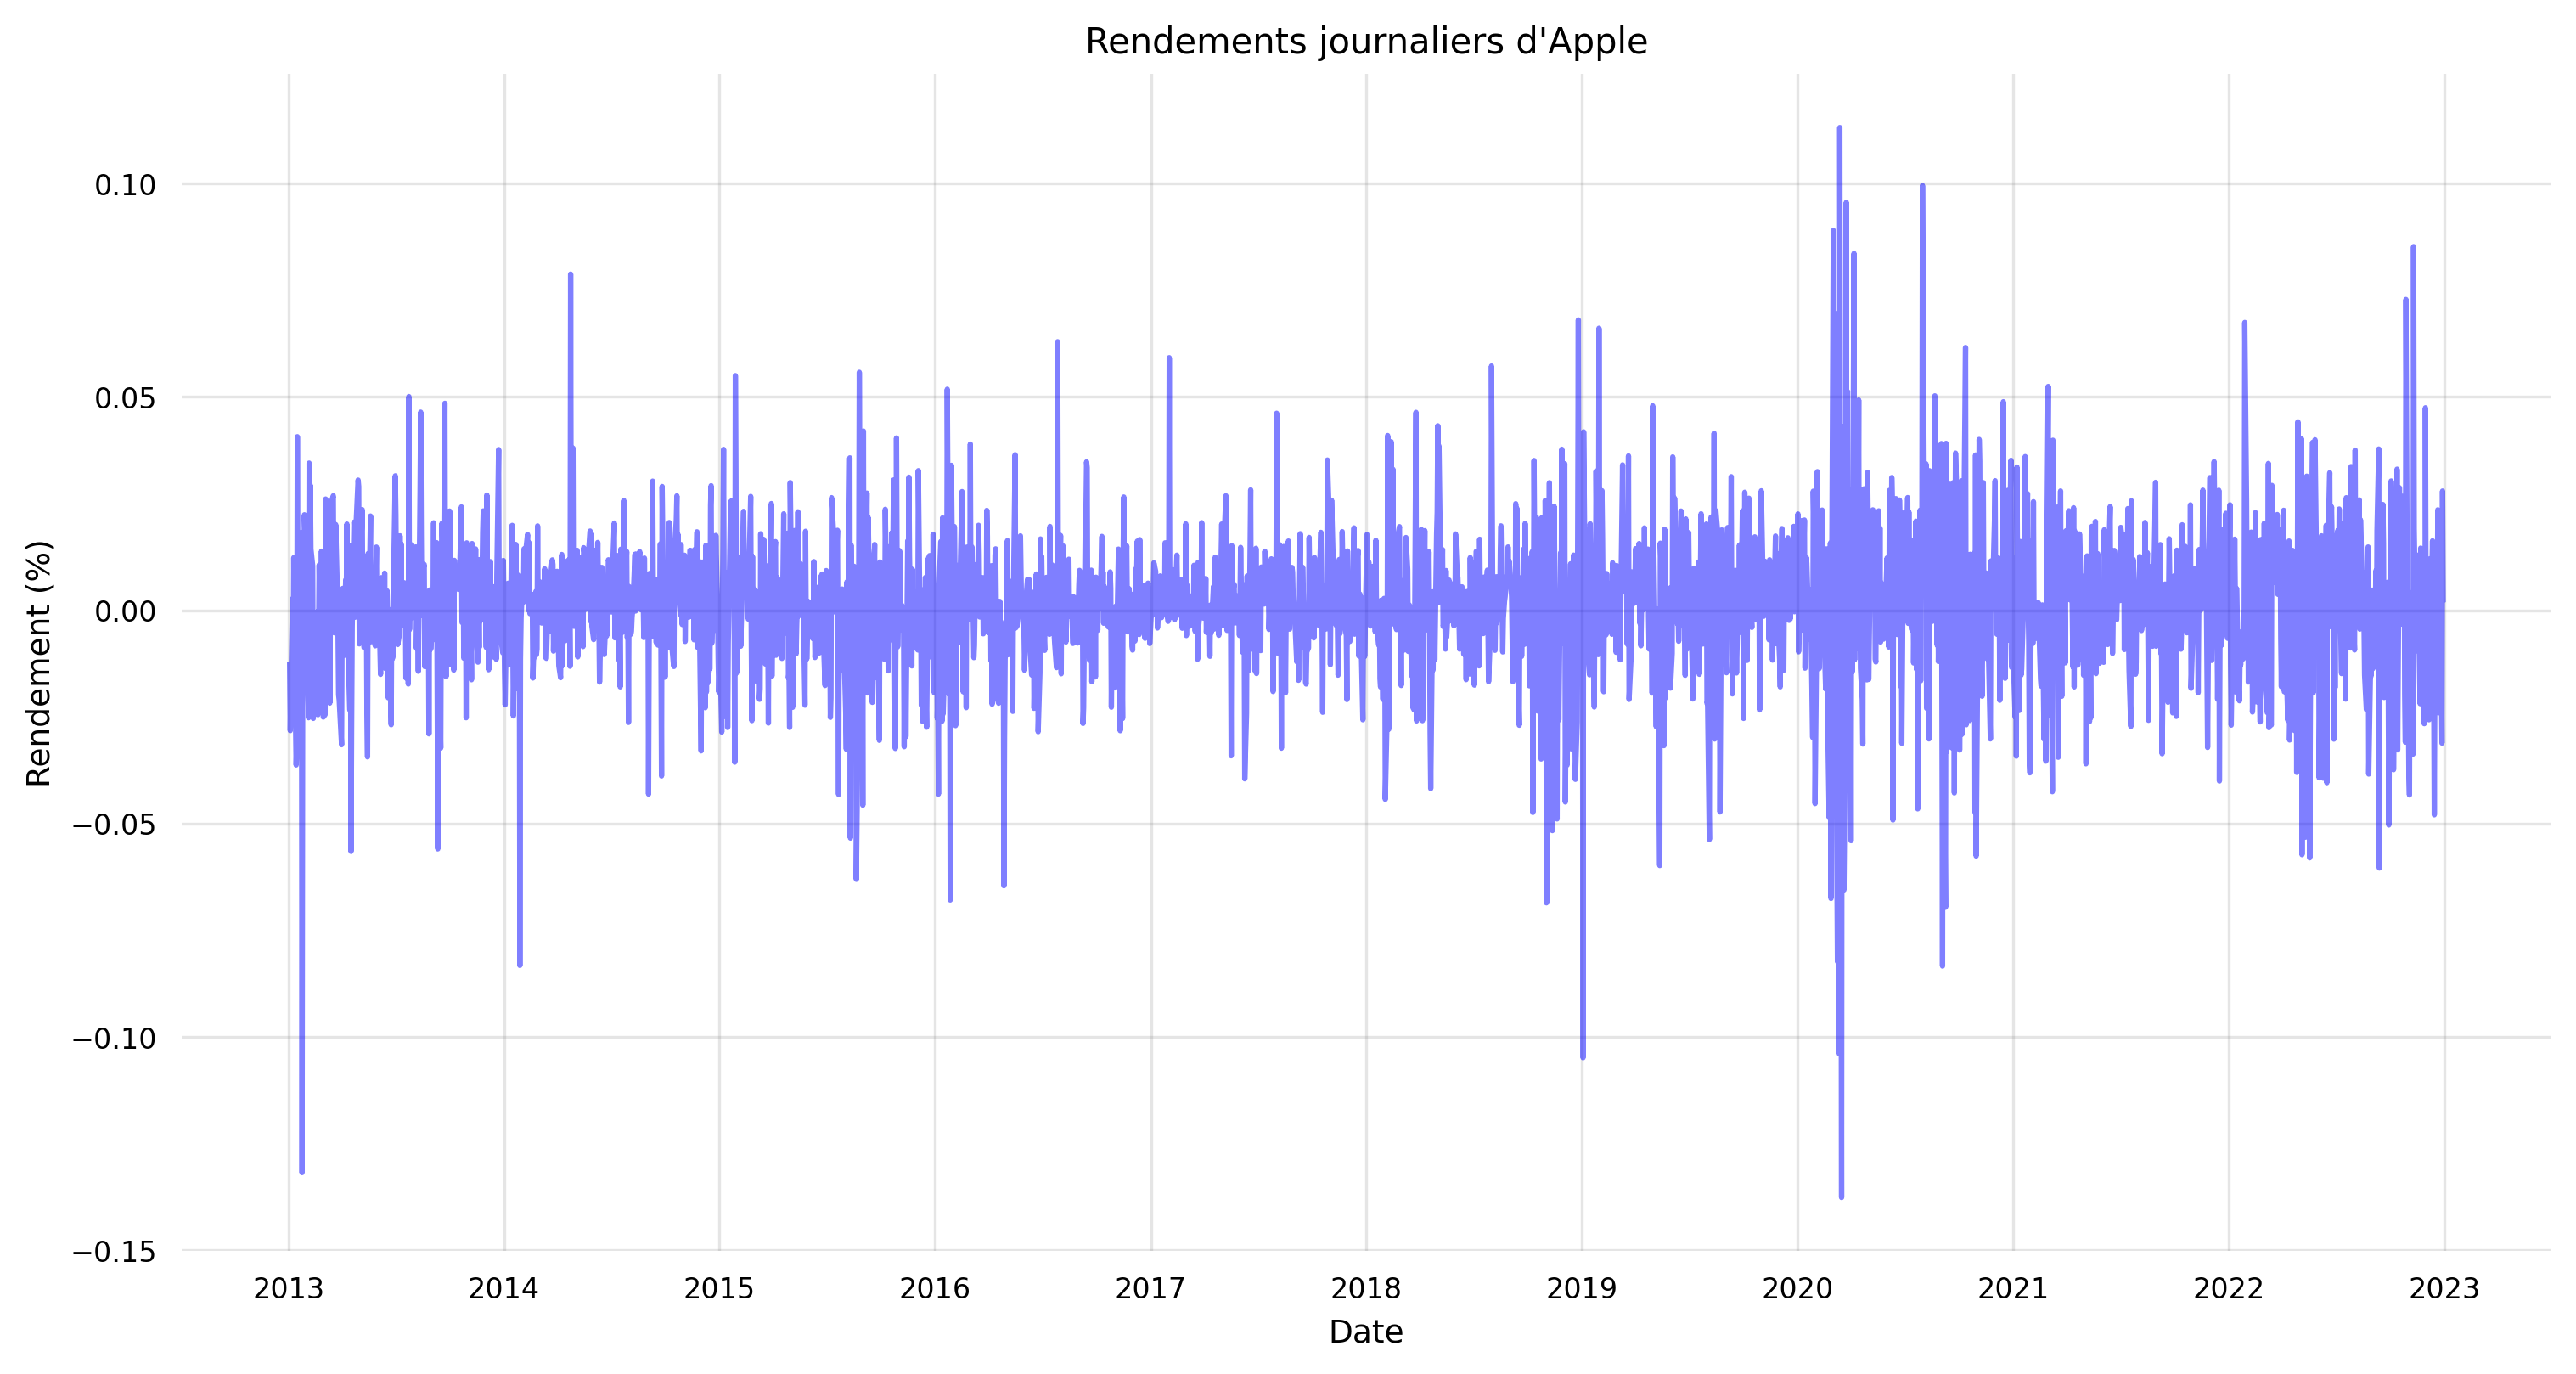

In [55]:
plt.plot(data['Date'], data['Log_Return'], color="blue", alpha=0.5)
plt.title("Rendements journaliers d'Apple")
#plt.axhline(0, color='black', linewidth=1, linestyle='--', alpha=0.5)
plt.xlabel("Date")
plt.ylabel("Rendement (%)")
plt.show()


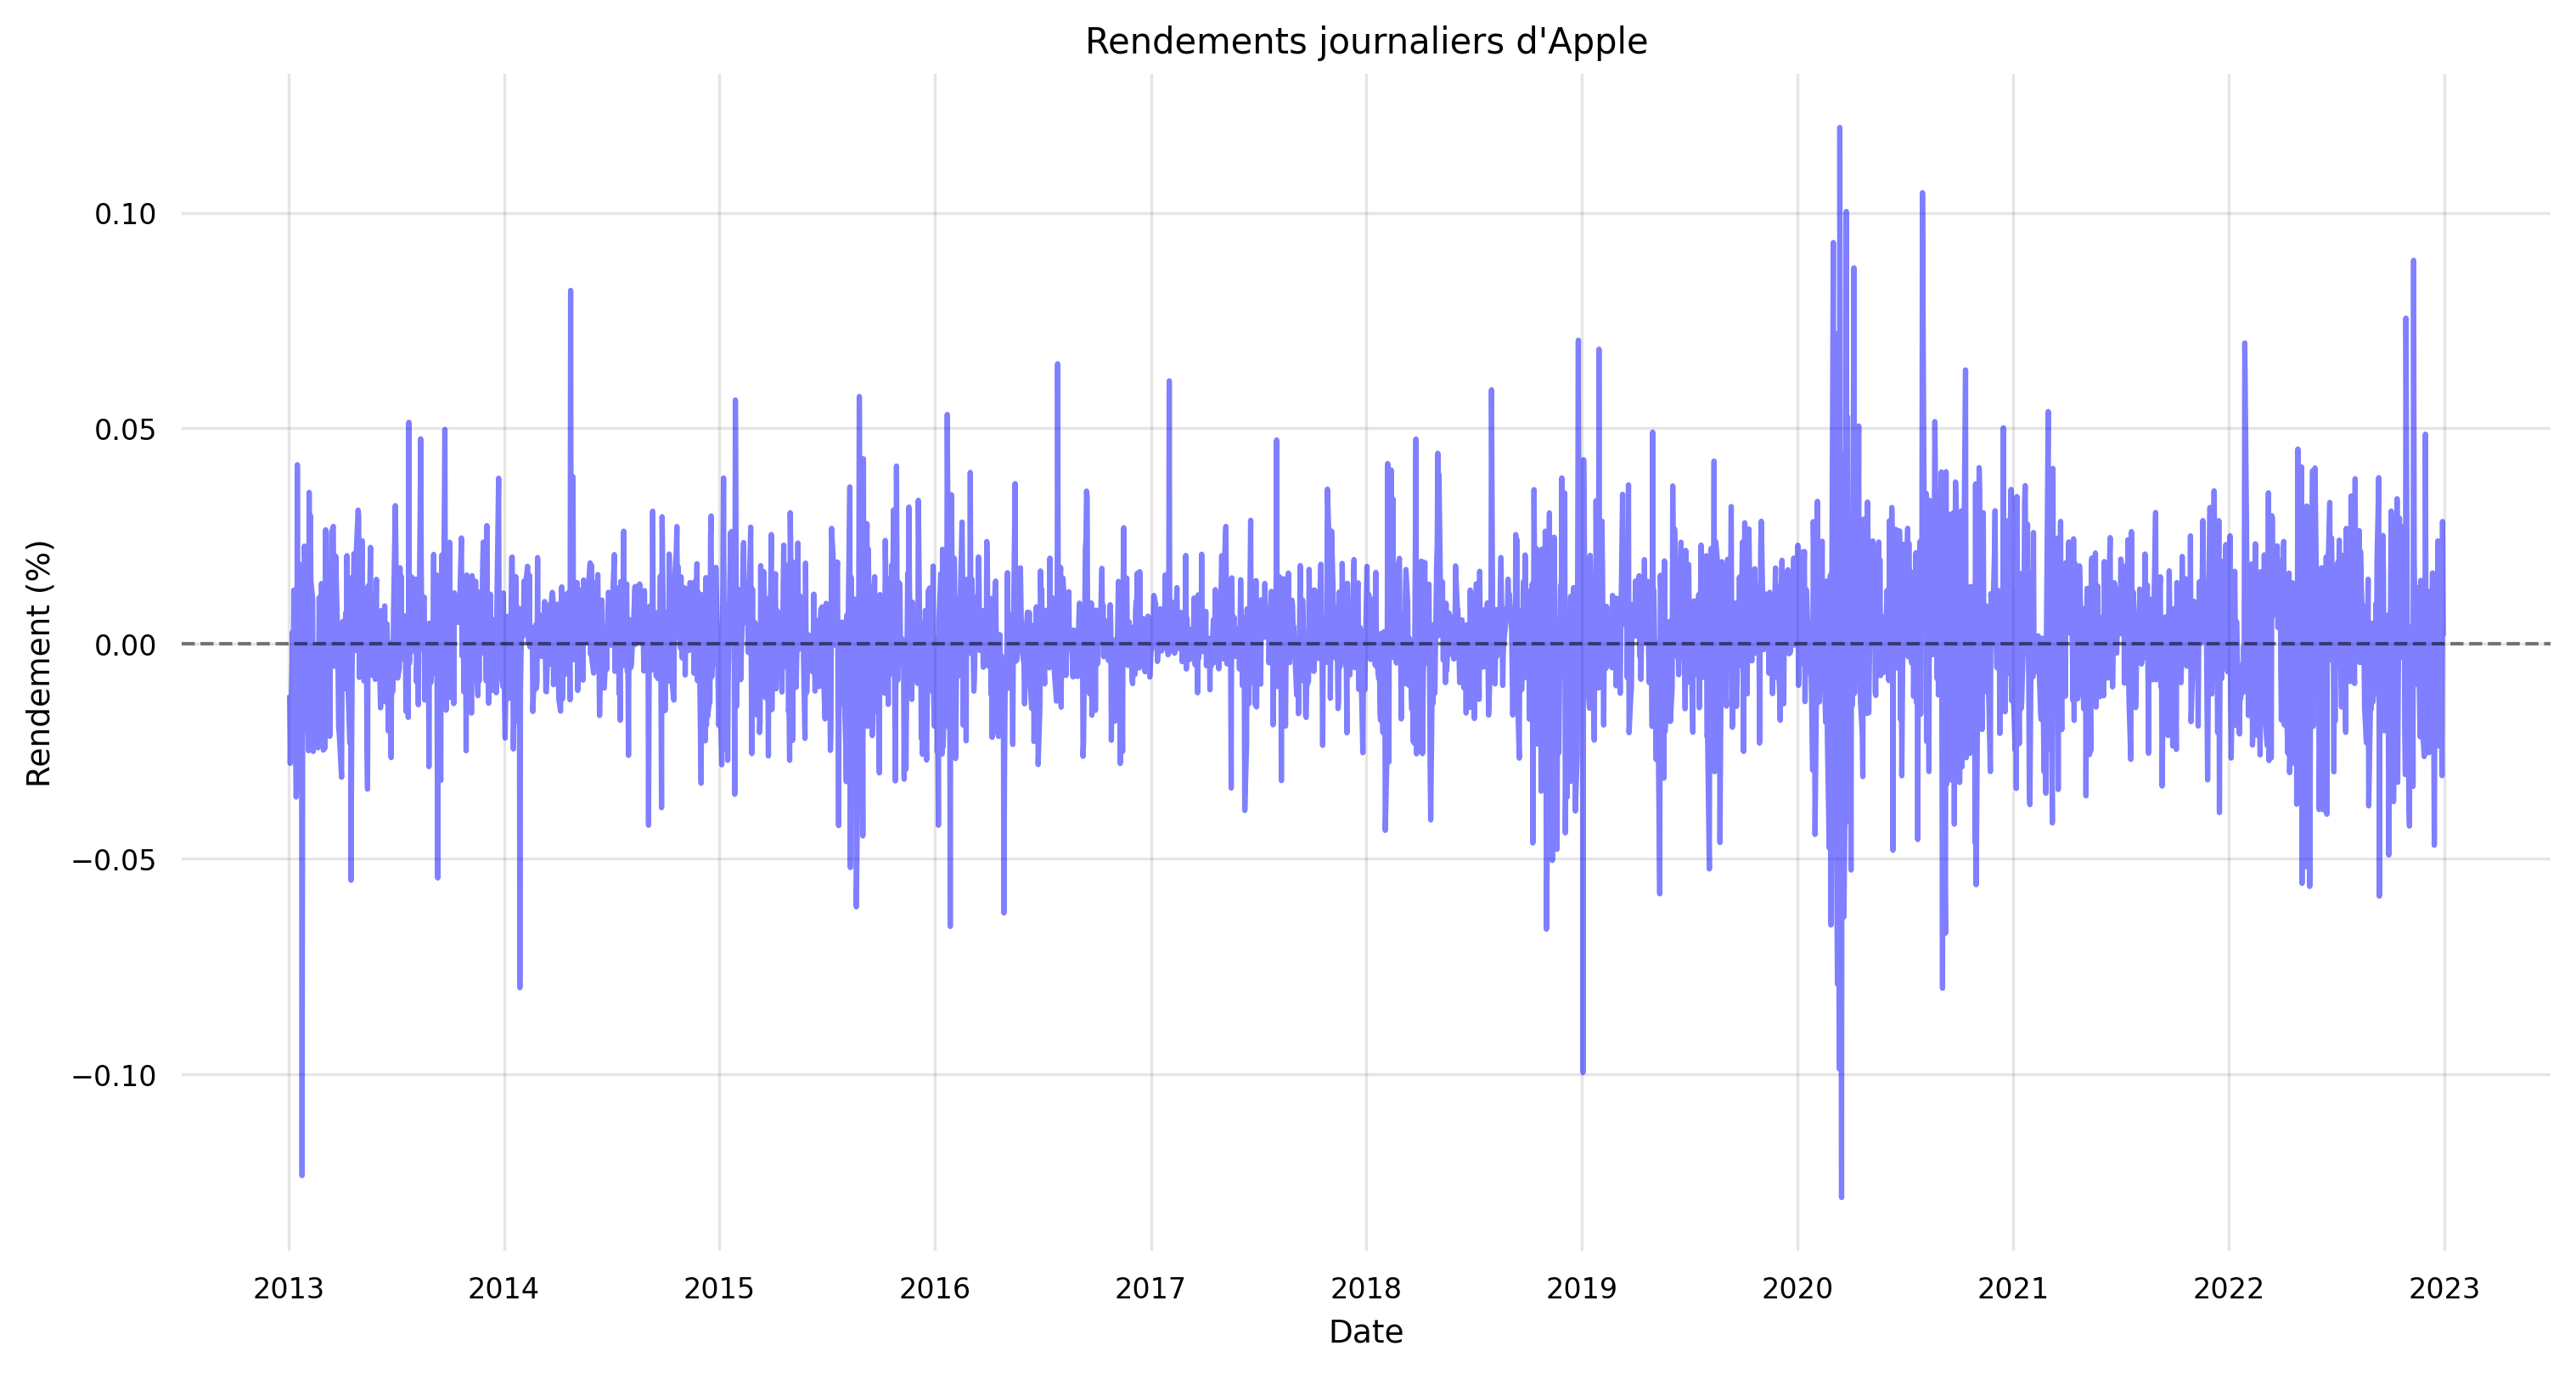

In [26]:
plt.plot(data['Date'], data['daily_return'], color="blue", alpha=0.5)
plt.title("Rendements journaliers d'Apple")
plt.axhline(0, color='black', linewidth=1, linestyle='--', alpha=0.5)
plt.xlabel("Date")
plt.ylabel("Rendement (%)")
plt.show()


In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume `data` is your DataFrame
correlation_matrix = data[['Open', 'High', 'Low', 'Close', 'Volume']].corr()

# Use Pandas Styler to apply a heatmap style
styled_corr = correlation_matrix.style.background_gradient(cmap='coolwarm')

styled_corr

,Open,High,Low,Close,Volume
Open,1.000000,0.999875,0.999842,0.999665,-0.445815
High,0.999875,1.000000,0.999820,0.999843,-0.443739
Low,0.999842,0.999820,1.000000,0.999849,-0.448662
Close,0.999665,0.999843,0.999849,1.000000,-0.446398
Volume,-0.445815,-0.443739,-0.448662,-0.446398,1.000000


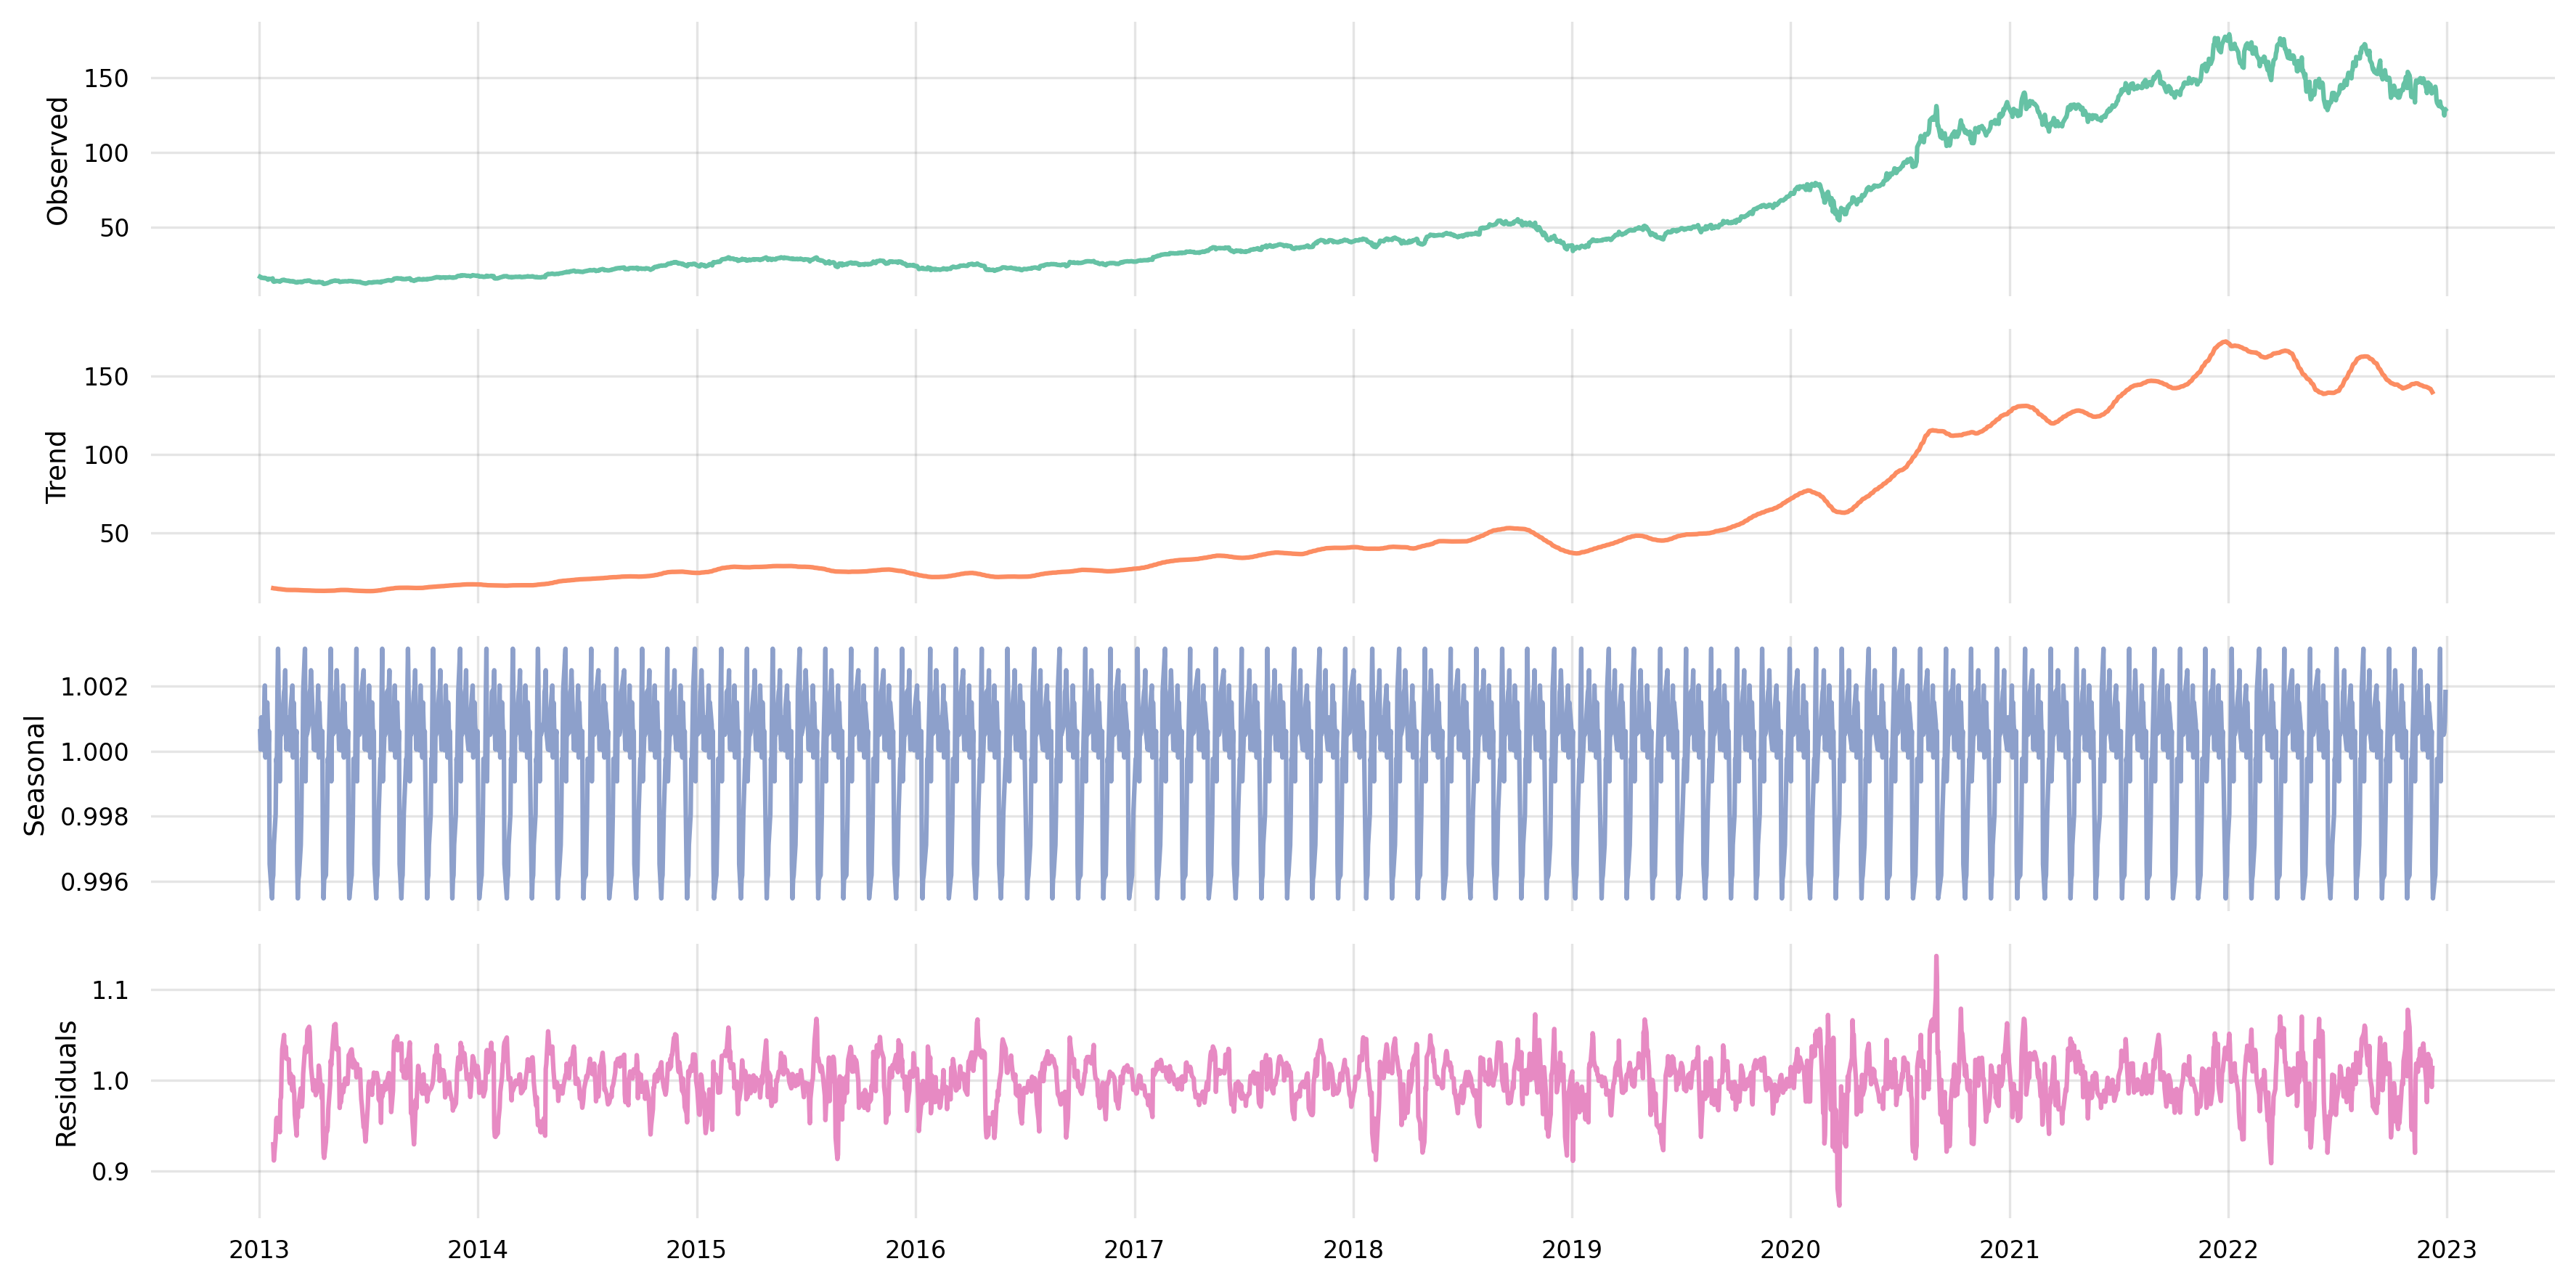

In [27]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Effectuer la décomposition
result = seasonal_decompose(data.set_index('Date')['Close'], model='multiplicative', period=30)

# Initialiser la figure avec 4 sous-graphes
fig, axes = plt.subplots(4, 1, figsize=(12, 6), sharex=True)
components = ['observed', 'trend', 'seasonal', 'resid']
titles = ['Observed', 'Trend', 'Seasonal', 'Residuals']
colors = px.colors.qualitative.Plotly[:4]
colors = sns.color_palette("Set2")[:4]
# Tracer chaque composante
for ax, comp, title, color in zip(axes, components, titles, colors):
    series = getattr(result, comp)
    ax.plot(series, label=title, color=color)
    ax.set_ylabel(title)
    ax.grid(True)

# Titre général et ajustement
plt.tight_layout() 
plt.show()


# NLP

In [ ]:
tweets

,id,body,date,user,source,symbols,owned_symbols,mentioned_users,entities,conversation,...,reshare_message,structurable,sentiment_base,body_cleaned,likes_total,likes_ponderation,sentiment_vader,sentiment_finbert,sentiment_roberta,one
0,188952625,$AAPL there is some smarty money trimming into...,2020-01-03,"{'id': 646025, 'username': 'WalterWhitesMoney'...","{'id': 1149, 'title': 'StockTwits for iOS', 'u...","[{'id': 686, 'symbol': 'AAPL', 'title': 'Apple...","['9', '4', '5', '0', '5', '12', '0', '0', '0',...",[],{'sentiment': None},None,...,None,None,nan,cashtag_AAPL there is some smarty money trimmi...,0,1.000000,Neutral,Bullish,Bearish,1
1,188952404,$AAPL boom!,2020-01-03,"{'id': 2975791, 'username': 'IntradayTradesmen...","{'id': 1149, 'title': 'StockTwits for iOS', 'u...","[{'id': 686, 'symbol': 'AAPL', 'title': 'Apple...","['21', '12', '9', '0', '9', '5', '0', '4', '0'...",[],{'sentiment': None},None,...,None,None,nan,cashtag_AAPL boom!,0,1.000000,Neutral,Bullish,Bullish,1
2,188952295,$AAPL this pos will not fall below mid VWAP.,2020-01-03,"{'id': 2975791, 'username': 'IntradayTradesmen...","{'id': 1149, 'title': 'StockTwits for iOS', 'u...","[{'id': 686, 'symbol': 'AAPL', 'title': 'Apple...","['20', '11', '9', '0', '9', '5', '0', '4', '0'...",[],{'sentiment': None},"{'parent_message_id': 188952295, 'in_reply_to_...",...,None,None,nan,cashtag_AAPL this pos will not fall below mid ...,0,1.000000,Neutral,Bullish,Bearish,1
3,188952260,$AAPL I am holding going to see what this bab...,2020-01-03,"{'id': 2083522, 'username': 'robertlooney', 'n...","{'id': 2095, 'title': 'StockTwits For Android ...","[{'id': 686, 'symbol': 'AAPL', 'title': 'Apple...","['4', '4', '0', '0', '0', '3', '0', '0', '0', ...",[],{'sentiment': {'basic': 'Bullish'}},None,...,None,None,Bullish,cashtag_AAPL I am holding going to see what t...,1,1.414214,Bullish,Bullish,Bullish,1
4,188951817,$SPY is $AAPL over priced is the average analy...,2020-01-03,"{'id': 1581841, 'username': 'CaymanStyleBeef',...","{'id': 2095, 'title': 'StockTwits For Android ...","[{'id': 686, 'symbol': 'AAPL', 'title': 'Apple...","['3', '2', '1', '0', '1', '1', '0', '1', '0', ...",[],{'sentiment': None},"{'parent_message_id': 188951817, 'in_reply_to_...",...,None,None,nan,cashtag_SPY is cashtag_AAPL over priced is the...,0,1.000000,Neutral,Bullish,Bearish,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914957,433483243,$AAPL break 171 and she flushes,2022-02-04,"{'id': 6291642, 'username': 'Russianrussian', ...","{'id': 1149, 'title': 'StockTwits for iOS', 'u...","[{'id': 686, 'symbol': 'AAPL', 'title': 'Apple...",None,[],{'sentiment': {'basic': 'Bearish'}},"{'parent_message_id': 433483243, 'in_reply_to_...",...,None,None,Bearish,cashtag_AAPL break 171 and she flushes,2,1.732051,Neutral,Bullish,Bearish,1
914958,433483137,$AAPL is a growth stock now?,2022-02-04,"{'id': 6287247, 'username': 'TheMarketIsRigged...","{'id': 1149, 'title': 'StockTwits for iOS', 'u...","[{'id': 686, 'symbol': 'AAPL', 'title': 'Apple...",None,[],{'sentiment': None},None,...,None,None,nan,cashtag_AAPL is a growth stock now?,0,1.000000,Bullish,Bullish,Bearish,1
914959,433482209,"$AAPL 🍏 Do you know what time it is…yep, that...",2022-02-04,"{'id': 819540, 'username': 'hoyasaxa1978', 'na...","{'id': 1149, 'title': 'StockTwits for iOS', 'u...","[{'id': 686, 'symbol': 'AAPL', 'title': 'Apple...",None,[],{'sentiment': {'basic': 'Bullish'}},None,...,None,None,Bullish,cashtag_AAPL :green_apple: Do you know what t...,0,1.000000,Neutral,Bullish,Bullish,1
914960,433482173,"$AAPL lol u buy the dip on it, not like $tsla",2022-02-04,"{'id': 1223497, 'username': 'RNAlivesmatter', ...","{'id': 2269, 'title': 'StockTwits Web', 'url':...","[{'id': 686, 'symbol': 'AAPL', 'title': 'Apple...",None,[],{'sentiment': {'basic': 'Bullish'}},None,...,None,None,Bullish,"cashtag_AAPL lol u buy the dip on it, not like...",0,1.000000,Bullish,Bullish,Bullish,1


In [118]:
sentiment_df = compute_weighted_sentiment_scores_three_classes(tweets, sentiment_col="sentiment_vader")
sentiment_df.sort_values(by="score")

,date,score,nb_tweets
67,2020-03-07,-0.075893,309
151,2020-05-30,-0.064747,153
61,2020-03-01,-0.059561,520
68,2020-03-08,-0.059225,496
89,2020-03-29,-0.056590,464
...,...,...,...
656,2021-10-17,0.418937,147
649,2021-10-10,0.429507,223
544,2021-06-27,0.494679,216
725,2021-12-25,0.530799,102


# Tests with regressions (not used in the final method)

In [11]:
model = arch_model(data['Log_Return'].dropna(), vol='Garch', p=1, q=1, rescale = False)
results = model.fit(disp='off')
residuals = results.resid
squared_residuals = residuals**2
arch_test = het_arch(squared_residuals)
print(f'ARCH test results:\n')
print(f'LM Statistic: {arch_test[0]}')
print(f'p-value: {arch_test[1]}')
print(f'F Statistic: {arch_test[2]}')
print(f'p-value: {arch_test[3]}')

ARCH test results:

LM Statistic: 204.39012098847314
p-value: 1.9584900248068844e-38
F Statistic: 22.15563073177779
p-value: 3.763216864651667e-40


In [12]:
model = arch_model(data['Log_Return'].dropna(), vol='Arch', p=1, rescale = False)
results = model.fit(disp='off')
print(results.summary())

save_arch_results_to_latex(results, p=1, q=None, model_type="ARCH")

                      Constant Mean - ARCH Model Results                      
Dep. Variable:             Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                6578.84
Distribution:                  Normal   AIC:                          -13151.7
Method:            Maximum Likelihood   BIC:                          -13134.2
                                        No. Observations:                 2517
Date:               jeu., mai 22 2025   Df Residuals:                     2516
Time:                        16:11:43   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.1647e-03  3.782e-04      3.079  2.074e-03 [4.

In [13]:
model = arch_model(data['Log_Return'].dropna(), vol='Arch', p=2, rescale = False)
results = model.fit(disp='off')
print(results.summary())

                      Constant Mean - ARCH Model Results                      
Dep. Variable:             Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                6630.05
Distribution:                  Normal   AIC:                          -13252.1
Method:            Maximum Likelihood   BIC:                          -13228.8
                                        No. Observations:                 2517
Date:               jeu., mai 22 2025   Df Residuals:                     2516
Time:                        16:11:46   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.2029e-03  3.800e-04      3.165  1.549e-03 [4.

In [15]:
model = arch_model(data['Log_Return'].dropna(), vol='Garch', p=1, q=1, rescale = False)
results = model.fit(disp='off')
print(results.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:             Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                6714.27
Distribution:                  Normal   AIC:                          -13420.5
Method:            Maximum Likelihood   BIC:                          -13397.2
                                        No. Observations:                 2517
Date:               jeu., mai 22 2025   Df Residuals:                     2516
Time:                        16:11:50   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.3664e-03  3.510e-05     38.932      0.000 [1.


Test ADF pour la série d'origine:
ADF Statistic: -0.4629491904666964
p-value: 0.8990461838265786
La série n'est pas stationnaire

Test ADF après différenciation :
ADF Statistic: -10.17682387712462
p-value: 6.857577581371488e-18
La série est stationnaire


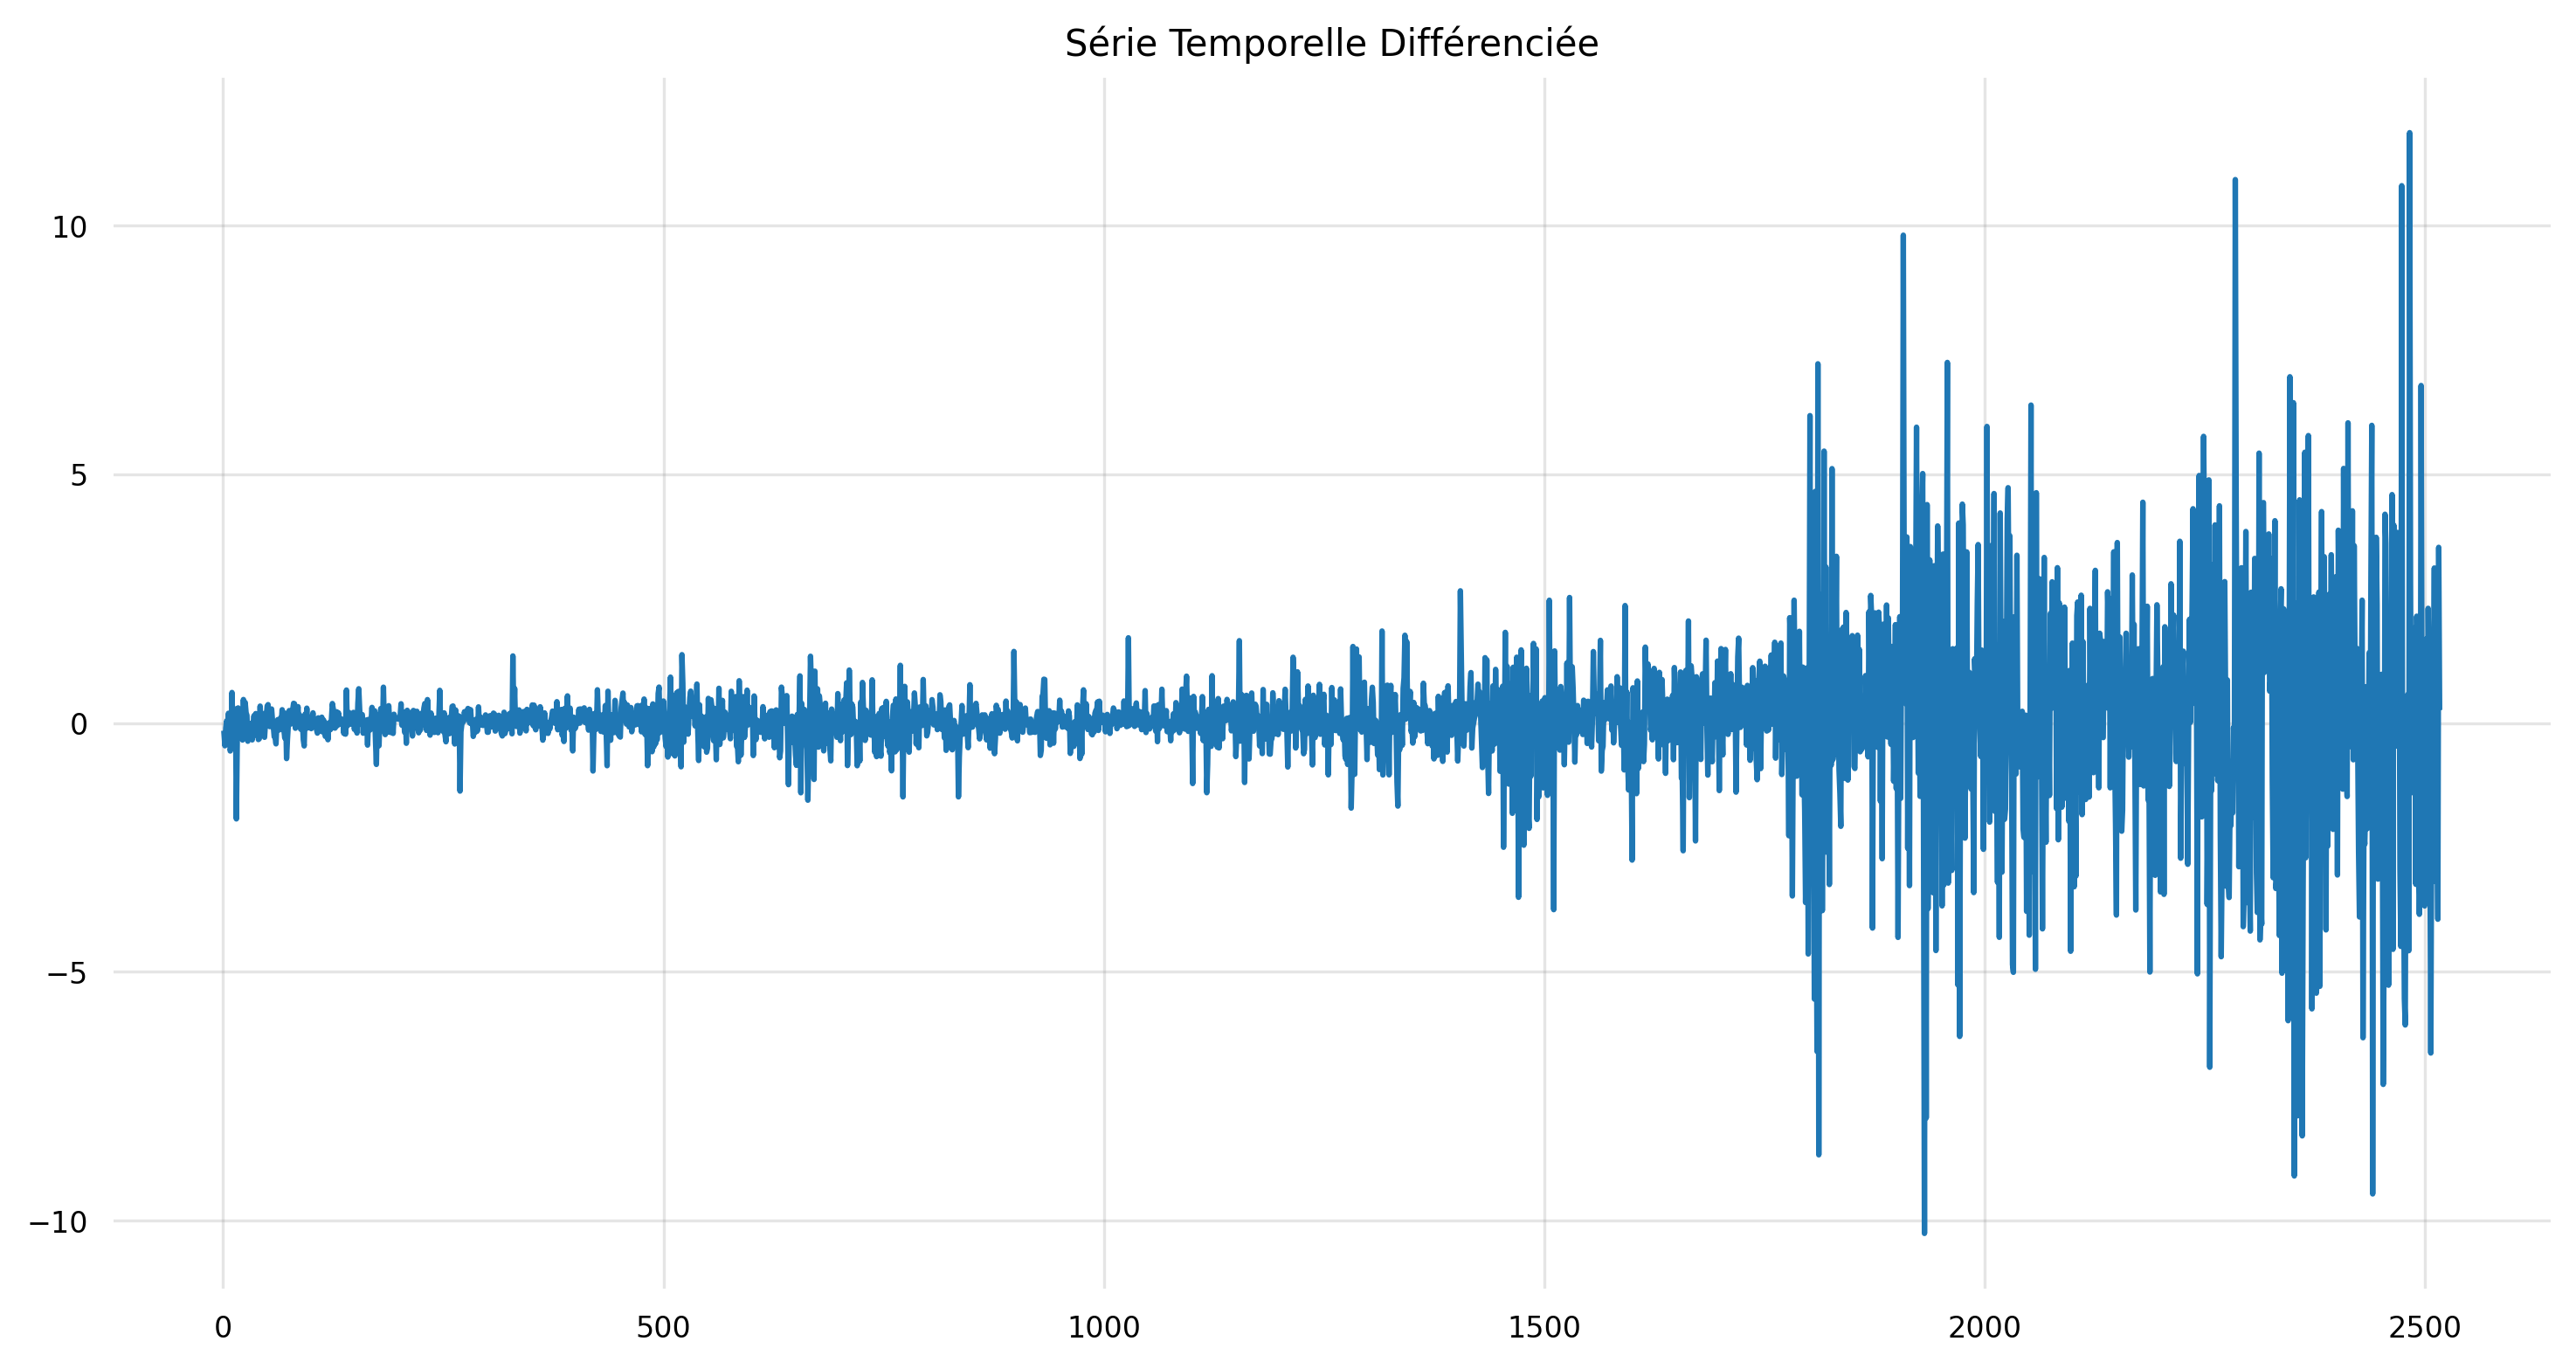

In [22]:
from statsmodels.tsa.stattools import adfuller, acf, pacf


def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print("La série est stationnaire")
    else:
        print("La série n'est pas stationnaire")

print("\nTest ADF pour la série d'origine:")
ts = data['Close'].dropna()
adf_test(ts)

# Différenciation pour rendre la série stationnaire
ts_diff = ts.diff().dropna()
print("\nTest ADF après différenciation :")
adf_test(ts_diff)

plt.figure(figsize=(12, 6))
plt.plot(ts_diff, label='Différenciée')
plt.title('Série Temporelle Différenciée')
plt.show()


Test ADF pour la série d'origine:
ADF Statistic: -16.226456340003057
p-value: 3.850609569539182e-29
La série est stationnaire

Test ADF après différenciation :
ADF Statistic: -16.027404100225517
p-value: 6.10990391369429e-29
La série est stationnaire


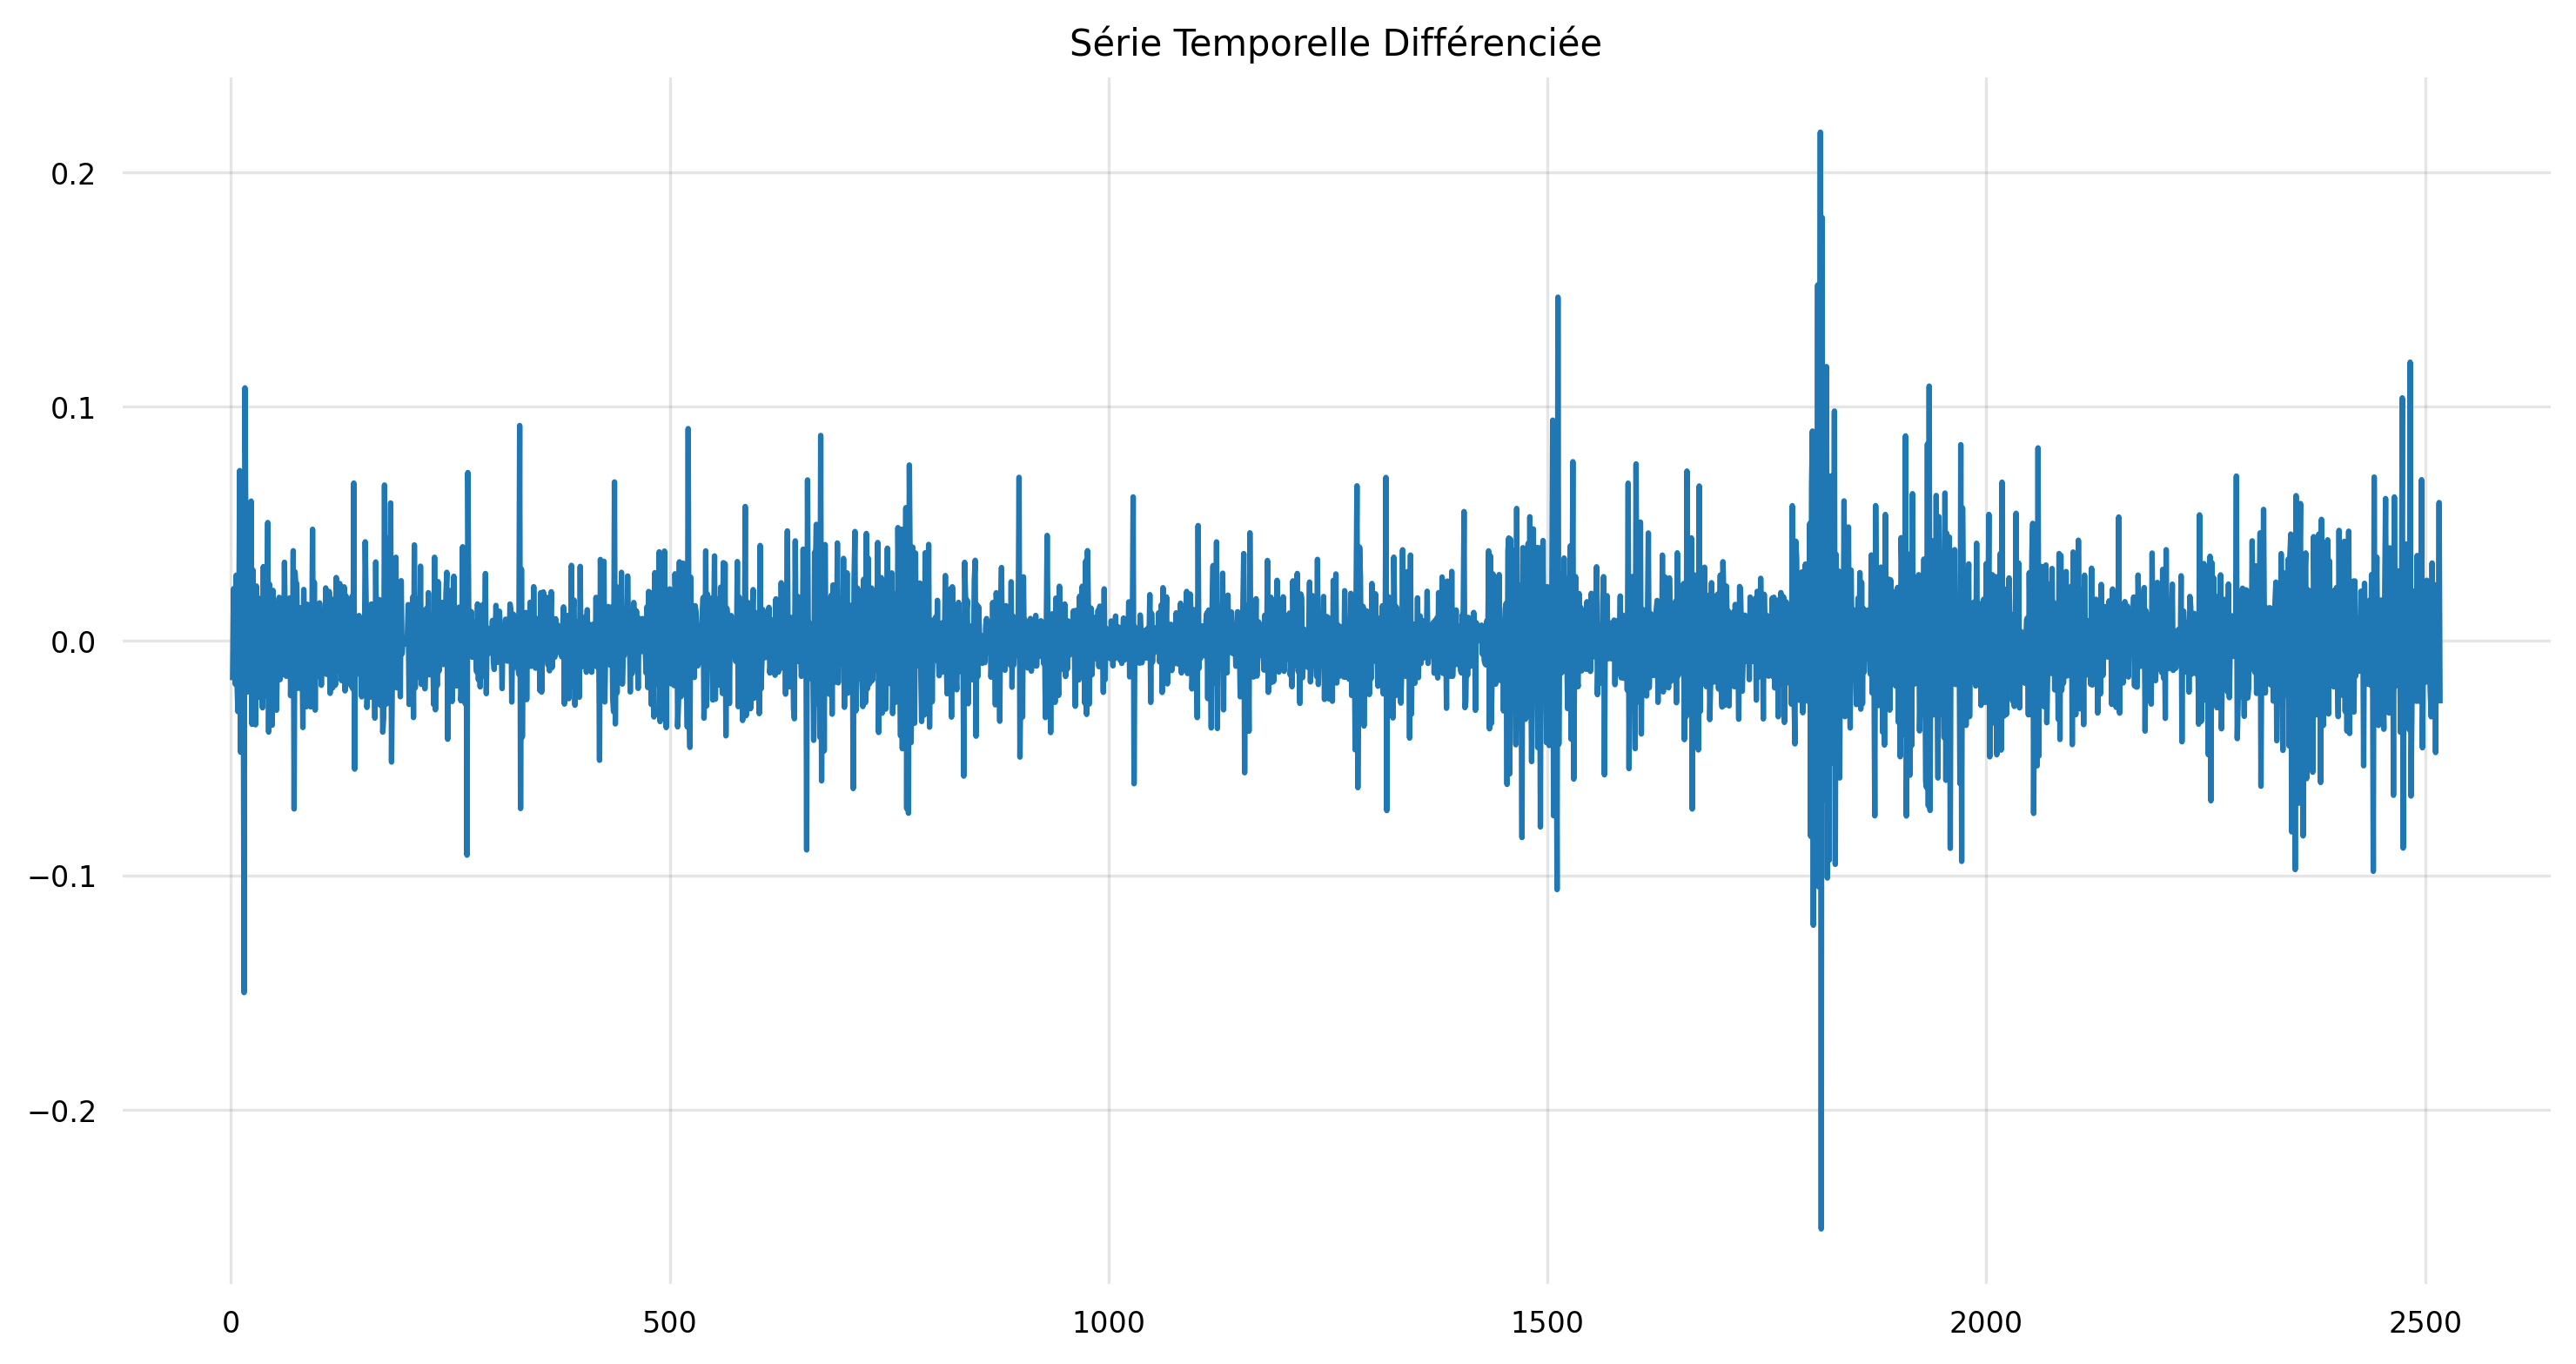

In [27]:
from statsmodels.tsa.stattools import adfuller, acf, pacf


def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print("La série est stationnaire")
    else:
        print("La série n'est pas stationnaire")

print("\nTest ADF pour la série d'origine:")
ts = data['Log_Return'].dropna()
adf_test(ts)

# Différenciation pour rendre la série stationnaire
ts_diff = ts.diff().dropna()
print("\nTest ADF après différenciation :")
adf_test(ts_diff)

plt.figure(figsize=(12, 6))
plt.plot(ts_diff, label='Différenciée')
plt.title('Série Temporelle Différenciée')
plt.show()

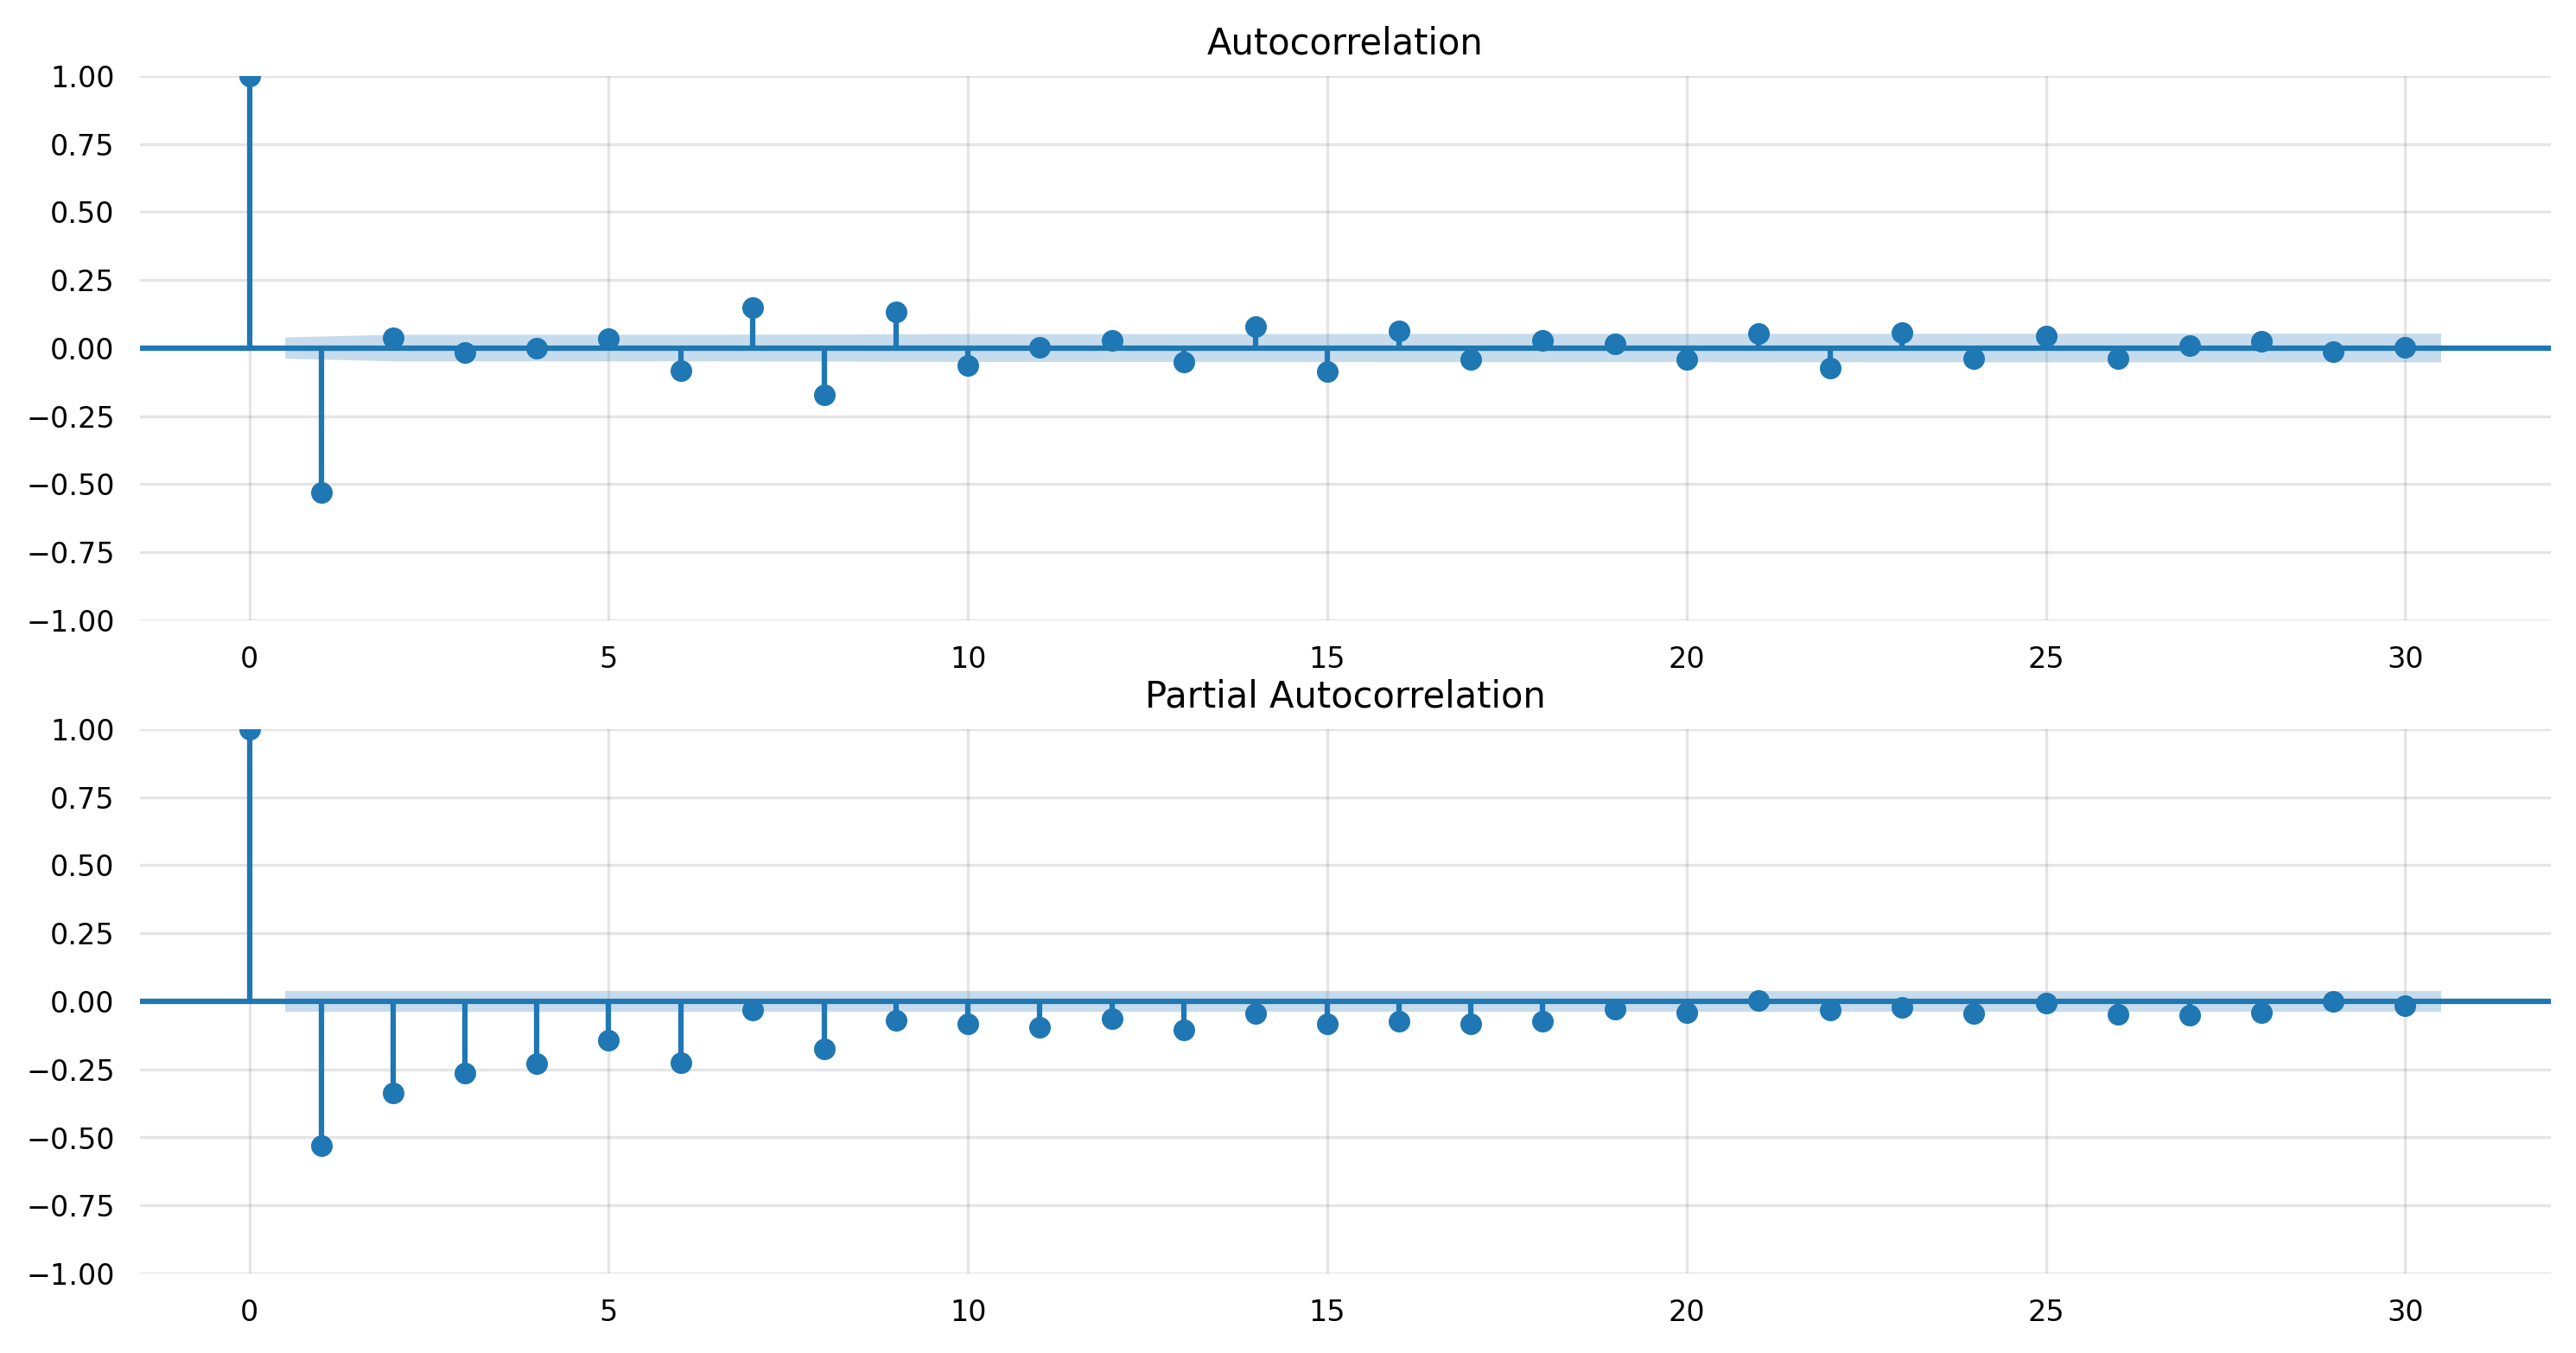

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import warnings

plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(ts_diff, lags=30, ax=plt.gca())
plt.subplot(212)
plot_pacf(ts_diff, lags=30, ax=plt.gca())
plt.show()

In [4]:
stock_prices = data['Close']
stock_prices = stock_prices.dropna()
train_size = int(len(stock_prices) * 0.8)
train_data, test_data = stock_prices[:train_size], stock_prices[train_size:]

In [5]:
test_data

2014    129.609100
2015    126.405235
2016    127.968063
2017    123.660484
2018    127.880165
           ...    
2513    130.344498
2514    128.535507
2515    124.591385
2516    128.120346
2517    128.436676
Name: Close, Length: 504, dtype: float64

In [8]:
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200 / (np.abs(y_pred) + np.abs(y_true))))

stock_prices = data.set_index('Date')['Close'].dropna()
train_size = int(len(stock_prices) * 0.8)
train_data, test_data = stock_prices[:train_size], stock_prices[train_size:]

train_ar = train_data.values
test_ar = test_data.values

model = auto_arima(train_ar, seasonal=False, stepwise=True, suppress_warnings=True, error_action="ignore")
model.fit(train_ar)

predictions = []

for t in range(len(test_ar)):
    yhat = model.predict(n_periods=1)[0]
    predictions.append(yhat)

    model.update(test_ar[t:t+1])

mse = mean_squared_error(test_ar, predictions)
smape = smape_kun(test_ar, predictions)

print(f'Testing Mean Squared Error: {mse:.3f}')
print(f'Symmetric Mean Absolute Percentage Error (sMAPE): {smape:.3f}')

Testing Mean Squared Error: 9.467
Symmetric Mean Absolute Percentage Error (sMAPE): 1.623


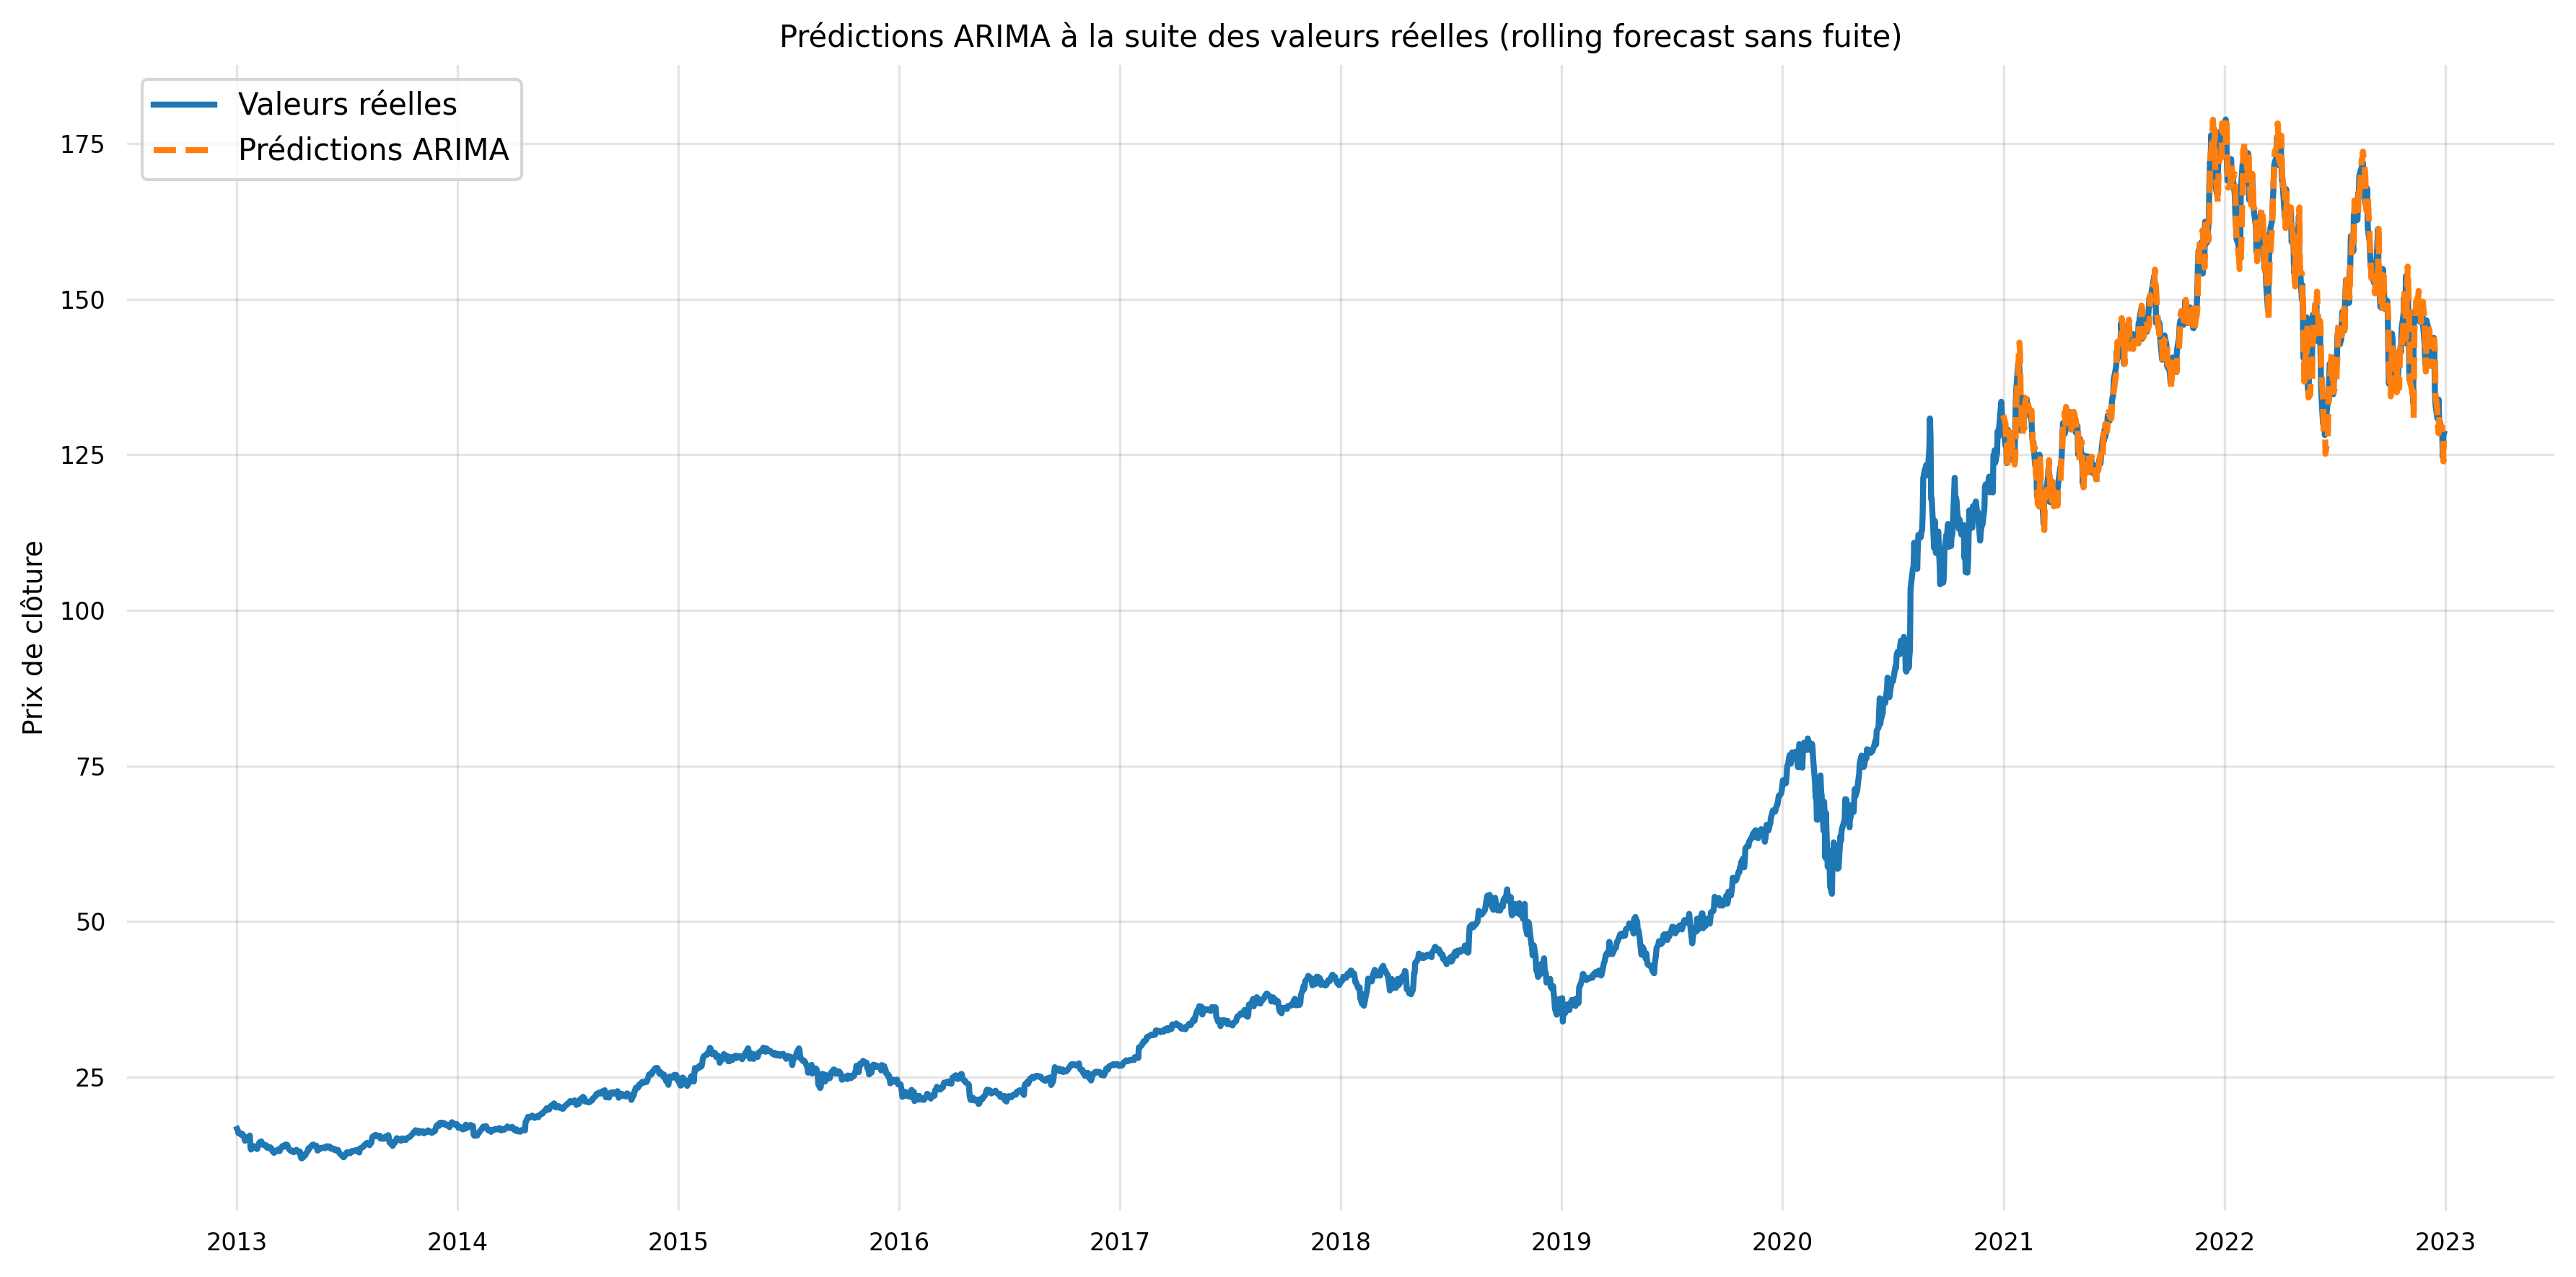

In [13]:
plt.figure(figsize=(12, 6))

plt.plot(stock_prices.index, stock_prices.values, label='Valeurs réelles', linewidth=2)

plt.plot(test_data.index, predictions, label='Prédictions ARIMA', linestyle='--', linewidth=2)

plt.title("Prédictions ARIMA à la suite des valeurs réelles (rolling forecast sans fuite)")
plt.ylabel("Prix de clôture")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Epoch 10/50 - Loss: 0.095584
Epoch 20/50 - Loss: 0.060350
Epoch 30/50 - Loss: 0.036969
Epoch 40/50 - Loss: 0.007284
Epoch 50/50 - Loss: 0.005873
Testing Mean Squared Error: 74.949
Symmetric Mean Absolute Percentage Error (sMAPE): 4.795


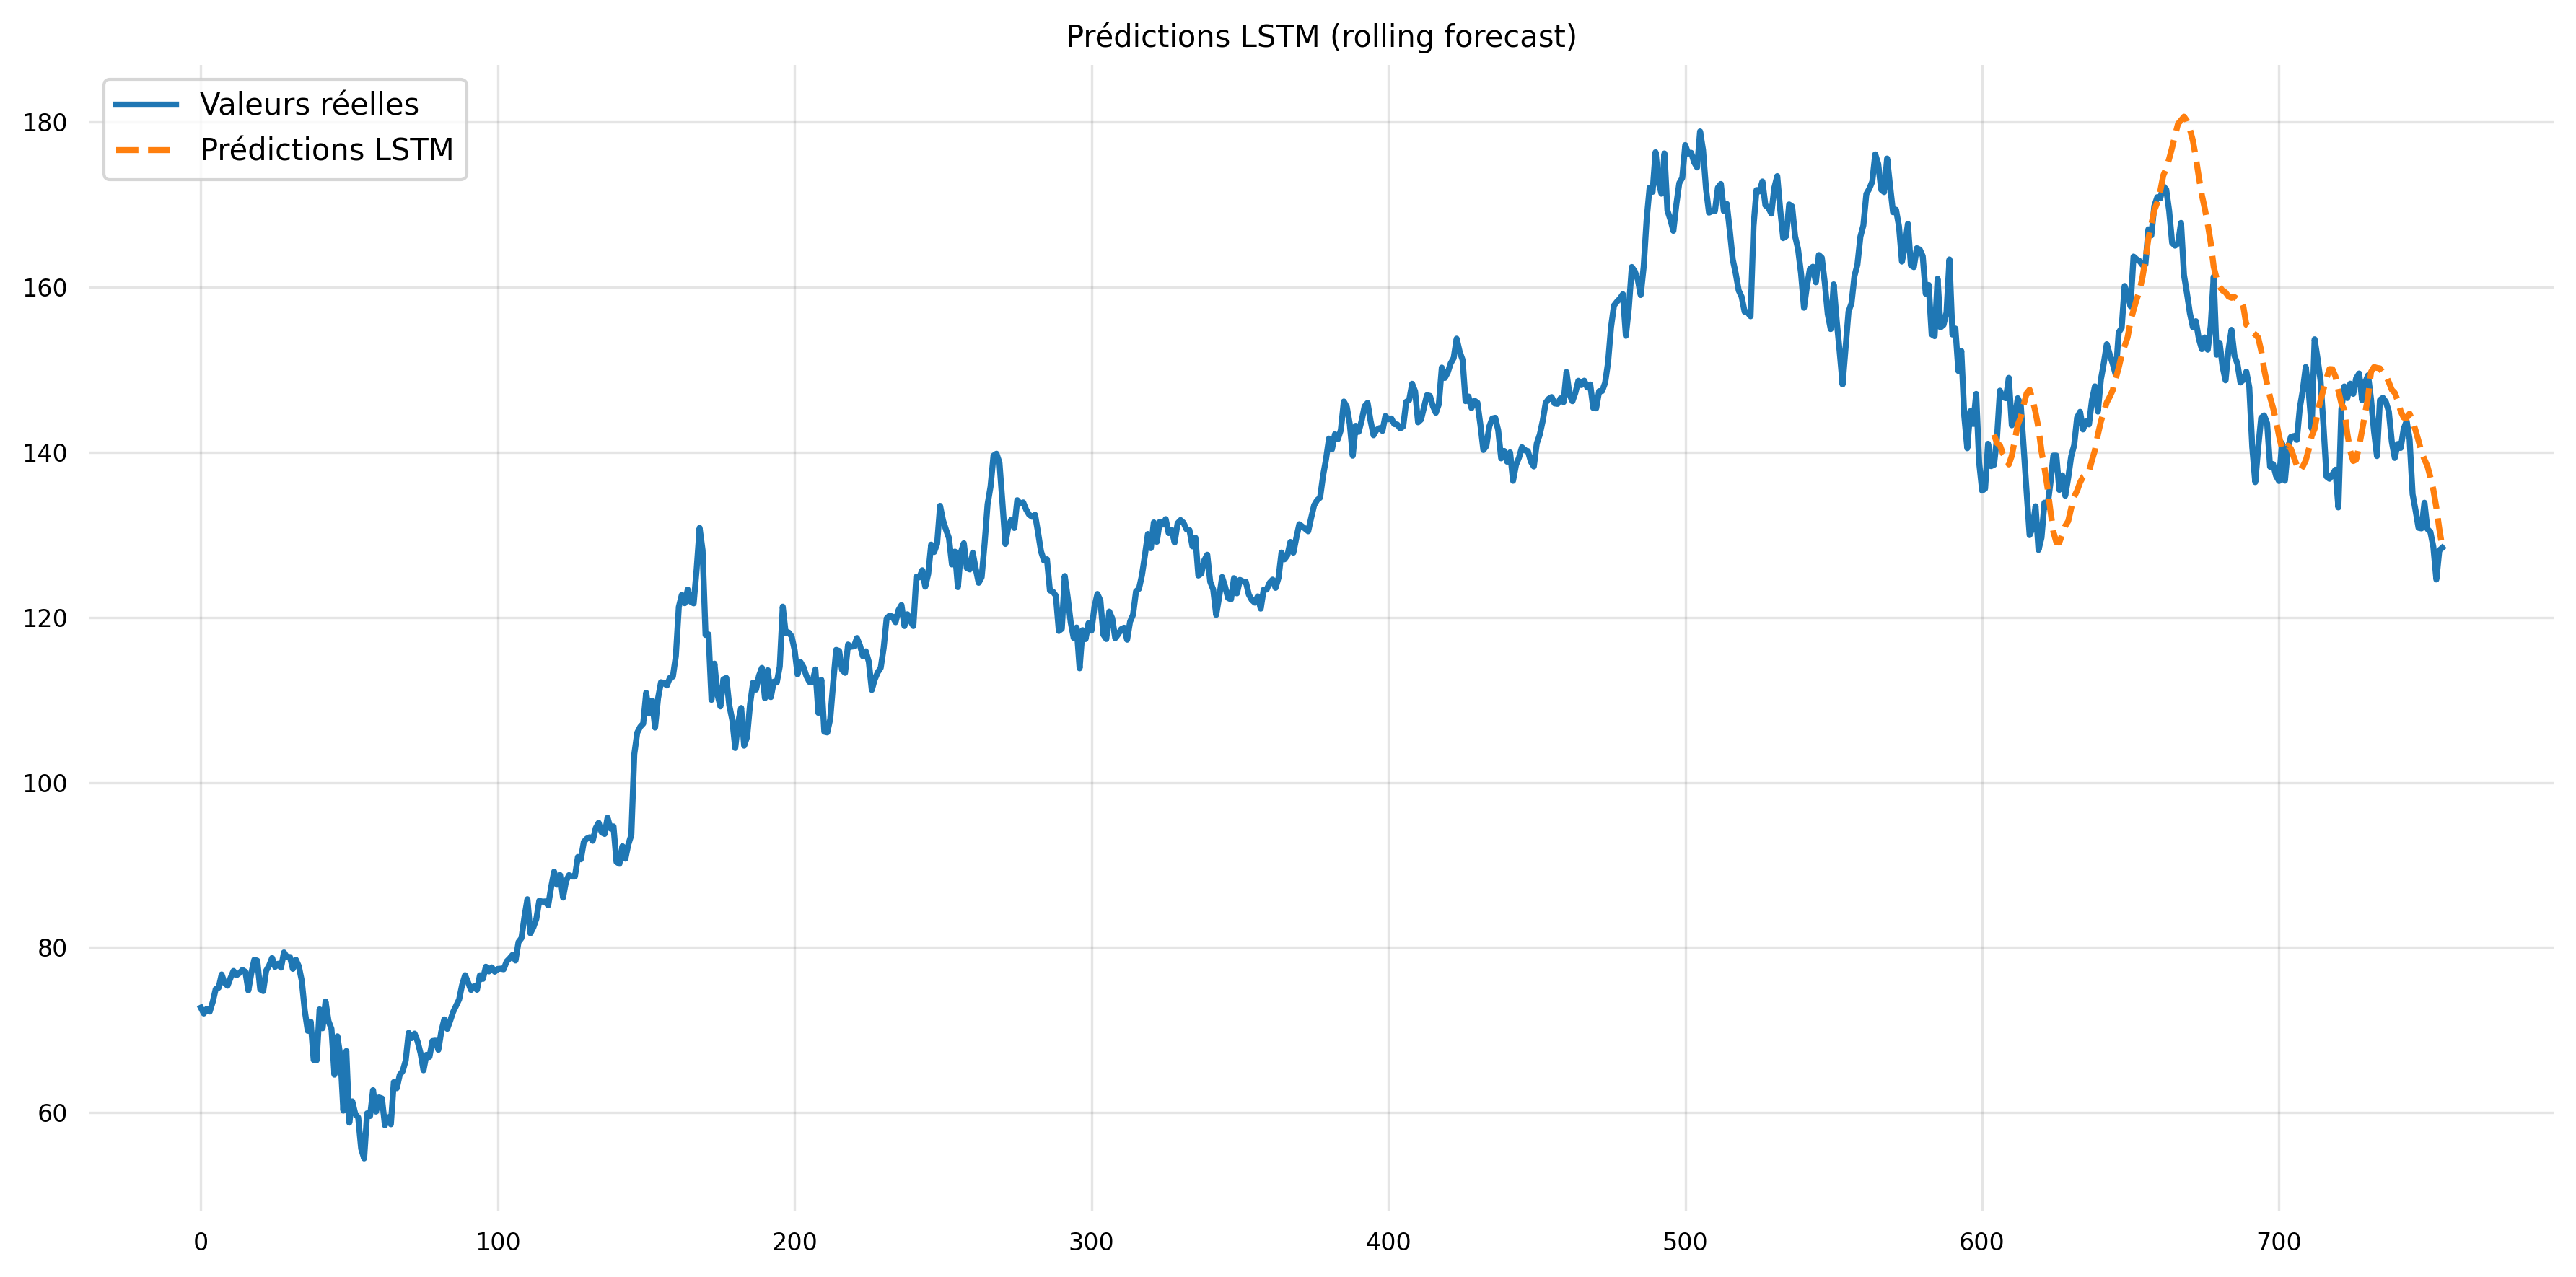

In [71]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# ⚙️ sMAPE
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200 / (np.abs(y_pred) + np.abs(y_true))))

# ⚙️ Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 📊 Données
stock_prices = data_new.set_index('Date')['Close'].dropna().values.reshape(-1, 1)
train_size = int(len(stock_prices) * 0.8)

scaler = MinMaxScaler()
stock_scaled = scaler.fit_transform(stock_prices)

train_scaled = stock_scaled[:train_size]
test_scaled = stock_scaled[train_size:]

# 🔁 Séquences
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

SEQ_LEN = 10
X_train, y_train = create_sequences(train_scaled, SEQ_LEN)

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)

# 🔧 Modèle LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=128, num_layers=3):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers,
                    batch_first=True, dropout=0.2)

        self.fc = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Dernier pas de temps
        return self.fc(out)

model = LSTMModel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 🏋️ Entraînement
EPOCHS = 50
for epoch in range(EPOCHS):
    model.train()
    output = model(X_train)
    loss = criterion(output, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {loss.item():.6f}")

# 🔮 Rolling forecast sur test set
model.eval()
inputs = train_scaled[-SEQ_LEN:].tolist()
predictions = []

for i in range(len(test_scaled)):
    seq = torch.tensor([inputs[-SEQ_LEN:]], dtype=torch.float32).to(device)
    with torch.no_grad():
        pred = model(seq).cpu().numpy().flatten()[0]
    predictions.append(pred)
    inputs.append([test_scaled[i][0]])  # update input with true value (no cheating)

# 🔁 Inverser la normalisation
pred_inv = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
test_true = scaler.inverse_transform(test_scaled).flatten()

# 📊 Évaluation
mse = mean_squared_error(test_true, pred_inv)
smape = smape_kun(test_true, pred_inv)

print(f'Testing Mean Squared Error: {mse:.3f}')
print(f'Symmetric Mean Absolute Percentage Error (sMAPE): {smape:.3f}')

# 📈 Visualisation
plt.figure(figsize=(12, 6))
plt.plot(range(len(stock_prices)), stock_prices, label="Valeurs réelles", linewidth=2)
plt.plot(range(train_size, train_size + len(pred_inv)), pred_inv, label="Prédictions LSTM", linestyle='--', linewidth=2)
plt.title("Prédictions LSTM (rolling forecast)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


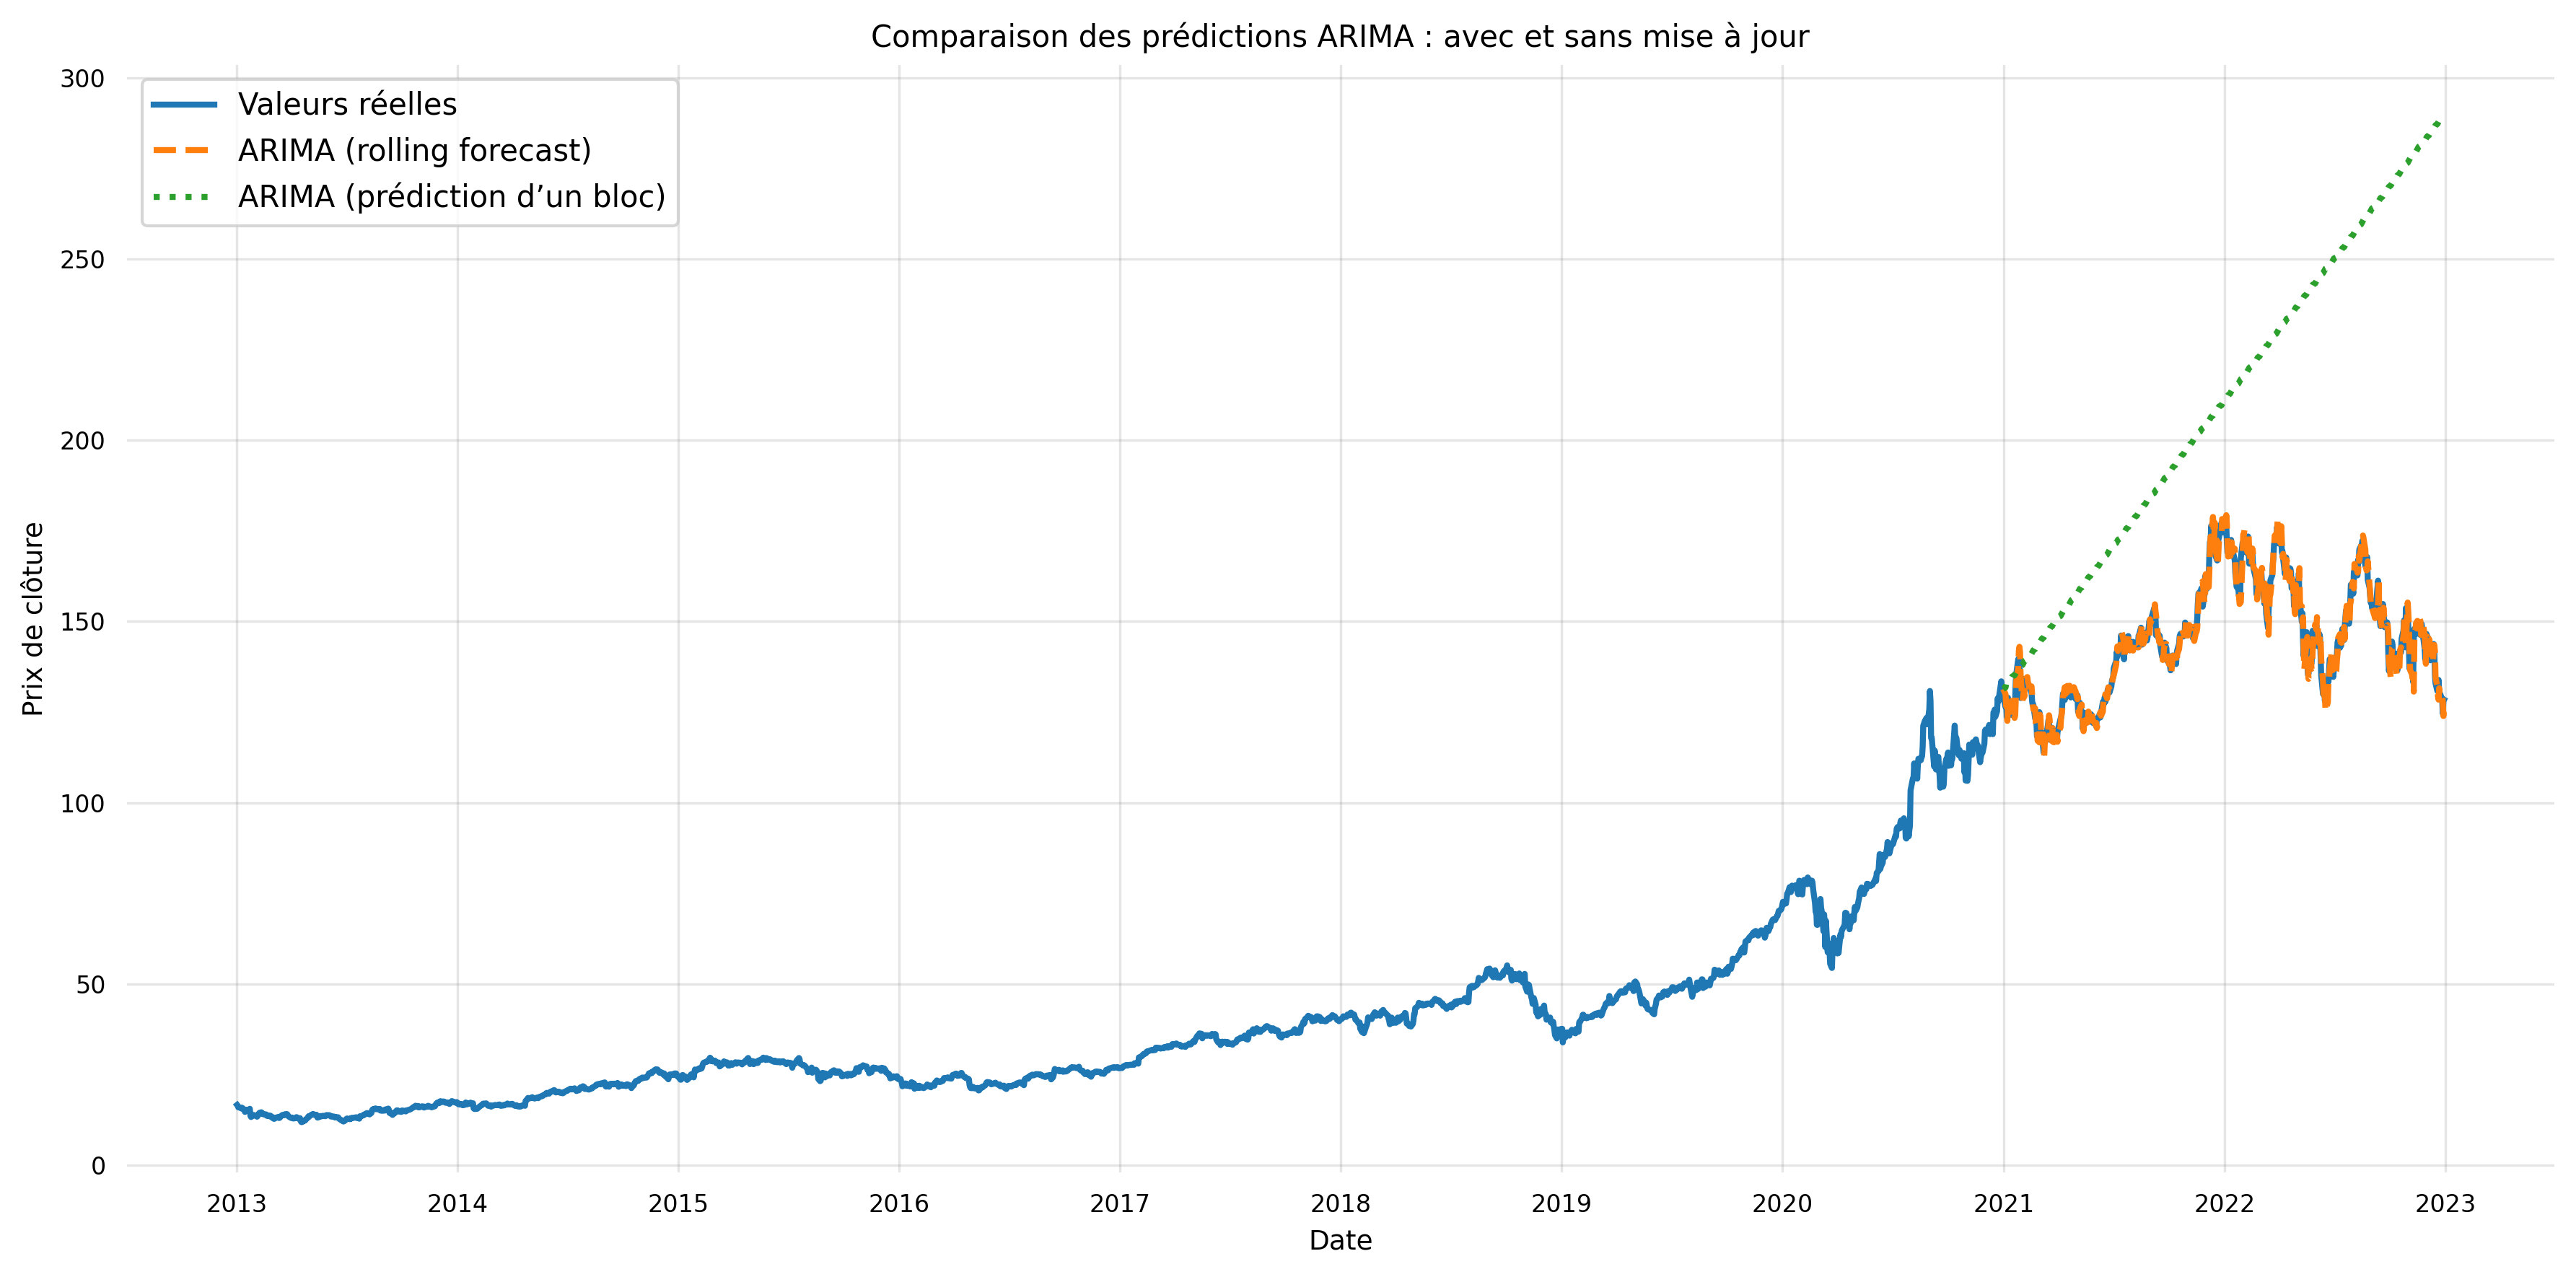

In [51]:
plt.figure(figsize=(12, 6))

# Courbe réelle
plt.plot(stock_prices.index, stock_prices.values, label='Valeurs réelles', linewidth=2)

# Rolling forecast ARIMA
plt.plot(test_data.index, predictions, '--', label='ARIMA (rolling forecast)', linewidth=2)

# Static ARIMA (sans update)
plt.plot(test_data.index, static_preds, ':', label='ARIMA (prédiction d’un bloc)', linewidth=2)

plt.title("Comparaison des prédictions ARIMA : avec et sans mise à jour")
plt.xlabel("Date")
plt.ylabel("Prix de clôture")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1763
Model:               SARIMAX(2, 2, 1)   Log Likelihood               -1333.087
Date:              dim., 01 juin 2025   AIC                           2674.175
Time:                        16:40:52   BIC                           2696.069
Sample:                             0   HQIC                          2682.266
                               - 1763                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0045      0.016      0.279      0.780      -0.027       0.036
ar.L2         -0.0596      0.018     -3.392      0.001      -0.094      -0.025
ma.L1         -0.9900      0.003   -360.499      0.0

c:\Users\zetru\projets_python\apple-stock-prediction\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


MSE sur les 30% finaux : 7.564
sMAPE sur les 30% finaux : 1.664%


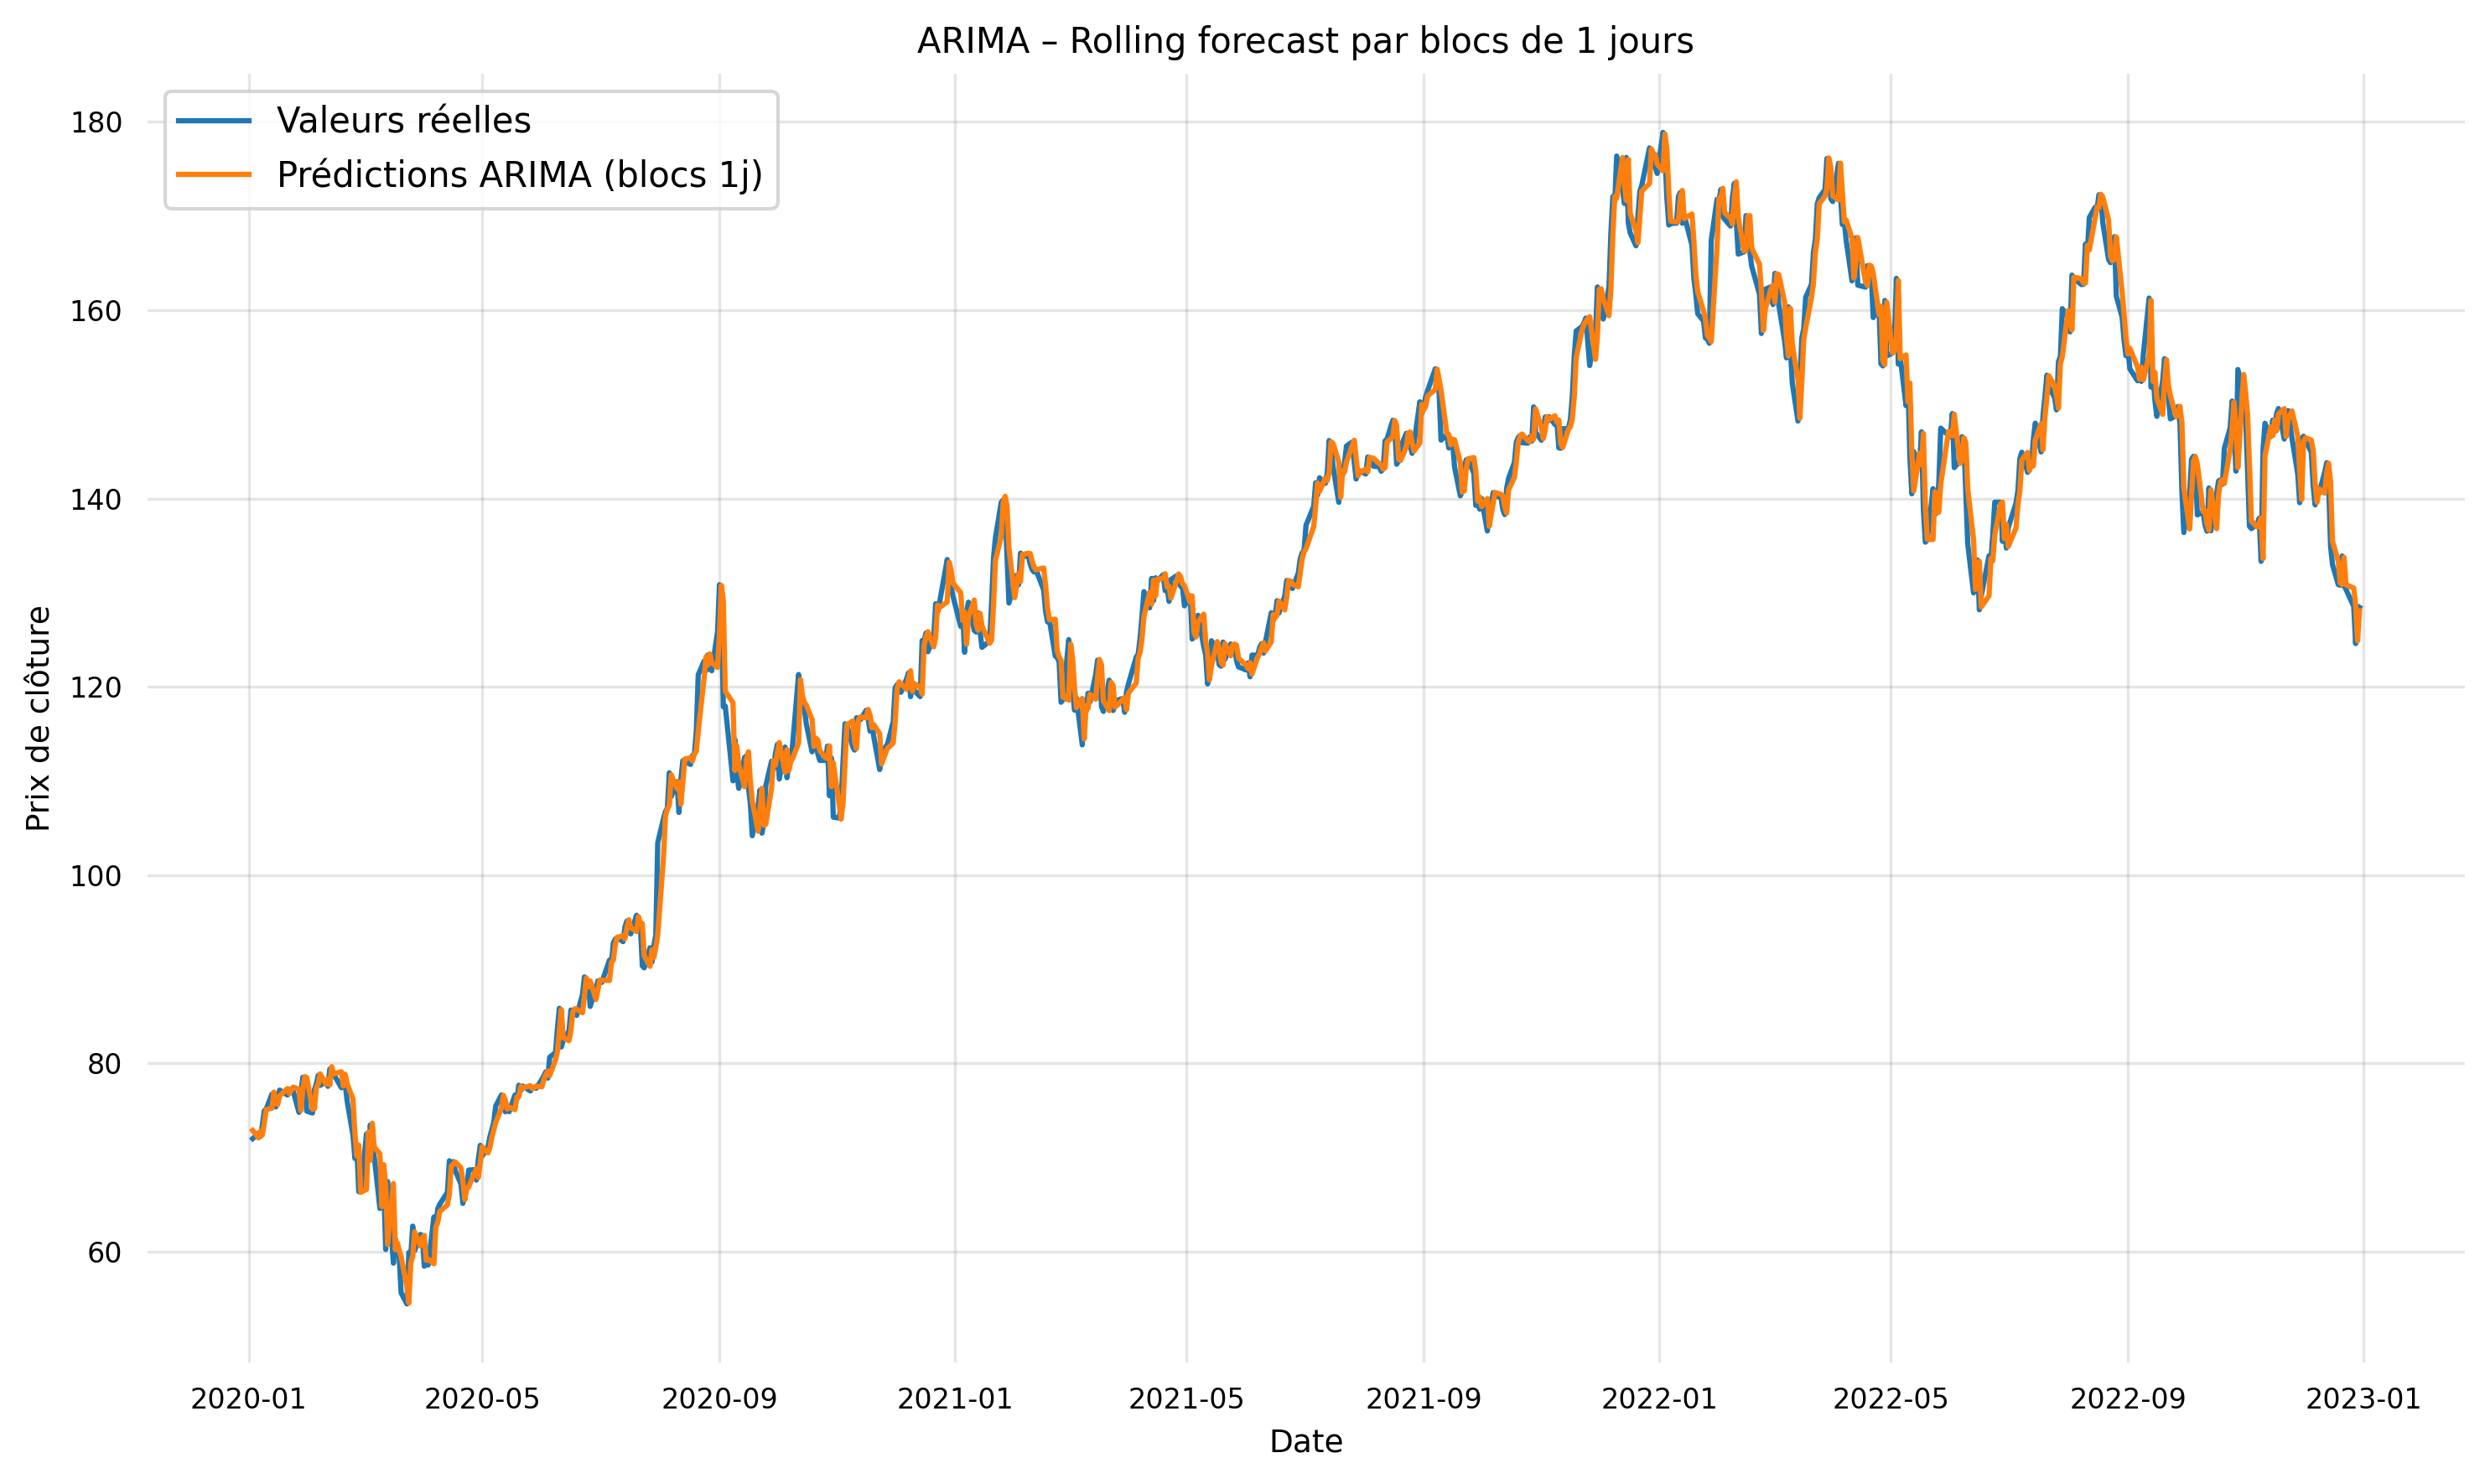

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error

def smape_kun(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true) * 200. / (np.abs(y_pred) + np.abs(y_true)))

# 1. Préparation des données
stock_prices = data.set_index('Date')['Close'].dropna()
n = len(stock_prices)
test_size = int(n * 0.3)
train_size = n - test_size

train_data = stock_prices.iloc[:train_size]
test_data  = stock_prices.iloc[train_size:]

# 2. Entraînement du modèle ARIMA avec sélection auto des ordres p,d,q ≤ 5
model = auto_arima(
    train_data,
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    max_d=3,
    seasonal=False,
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore'
)
model.fit(train_data)
print(model.summary())

# 3. Rolling forecast par blocs de 5 jours
block_size   = 1
predictions  = []

# on itère sur la série de test par pas de 5
for start in range(0, len(test_data), block_size):
    block = test_data.iloc[start:start+block_size]
    h = len(block)  # dernier bloc peut être plus petit que 5

    # on prédit h pas d'avance en un seul appel
    preds = model.predict(n_periods=h)
    predictions.extend(preds)

    # on met à jour le modèle (filtre) avec les vraies valeurs du bloc
    model.update(block.values)

# 4. Évaluation
pred_series = test_data.copy()
pred_series[:] = predictions

mse   = mean_squared_error(test_data, pred_series)
smape = smape_kun(test_data.values, pred_series.values)
print(f'MSE sur les 30% finaux : {mse:.3f}')
print(f'sMAPE sur les 30% finaux : {smape:.3f}%')

# 5. Affichage
plt.figure(figsize=(10,6))
plt.plot(test_data.index,       test_data.values,   label='Valeurs réelles')
plt.plot(test_data.index, pred_series.values, label=f'Prédictions ARIMA (blocs {block_size}j)')
plt.xlabel('Date')
plt.ylabel('Prix de clôture')
plt.title(f'ARIMA – Rolling forecast par blocs de {block_size} jours')
plt.legend()
plt.tight_layout()
plt.show()


In [32]:
data.to_parquet("stock_data.parquet")

# Predictions with stock prices only

Classic SVM

In [ ]:
features_df = data.set_index('Date')[['Log_Return']].dropna()

param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__gamma': ['scale']
}

window_sizes = np.arange(220, 250)

results_df = rolling_svm_pipeline(
    features_df=features_df,
    window_sizes=window_sizes,
    param_grid=param_grid
)

display(results_df)

Ensemble SVM (boosting)

In [ ]:
param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__gamma': ['scale']
}

results = rolling_ensemble_svm_pipeline(
    features_df= features_df,
    window_sizes= [200, 230, 240, 250, 300],
    param_grid= param_grid,
    n_jobs=1,
    n_estimators=1
)
display(results)

LSTM

In [ ]:
features_df = data.set_index('Date')[['Log_Return']].dropna()
device = "cuda" if torch.cuda.is_available() else "cpu"

param_grid_lstm = {
    "lstm_units":    [25, 50, 100],       # nombre d’unités cachées dans le LSTM
    "dropout":       [0.0, 0.2, 0.5],     # taux de dropout entre les couches récurrentes
    "learning_rate": [1e-2, 1e-3, 1e-4],  # taux d’apprentissage (Adam/RMSprop)
    "batch_size":    [16, 32, 64],        # taille de batch
    "epochs":        [50, 100, 200],      # nombre d’époques d’entraînement
}

df_perf = rolling_lstm_pipeline(
     features_df=features_df,
     test_fraction=0.3,
     target_col="Log_Return",
     device="cpu",
     window_sizes=[200, 230, 240, 250, 300],
     param_grid=param_grid_lstm,
     n_features=1
 )
display(df_perf)